In [1]:
# Enable outputting results interactively. 
# All the results from code in a given cell will be displayed instead of only the last one.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:

import plotly.plotly as py
import plotly.graph_objs as go
import plotly

import cufflinks
cufflinks.go_offline(connected=True)

In [3]:
import folium

from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

import geopandas as gpd
import json

from shapely.geometry import shape, Point

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [5]:
import pandas as pd
import pickle
import numpy as np
import scipy.stats as stats
import sqlite3
import math
import datetime
import matplotlib.dates as mdates

from re import sub
from decimal import Decimal

import re

In [6]:
listings_0 =  pickle.load( open( "../data/all_SF_listings.p", "rb" ) )

reviews =  pickle.load( open( "../data/all_SF_reviews.p", "rb" ) )


In [7]:
len(set(listings_0['id']))

29894

In [8]:
# Flag listings of which the min. nights is less than 30 days. Rentals of 30 days and above are not subject to the new regulations.

# boolean values;

listings_0['short_term'] = (listings_0['minimum_nights']<30) * 1 
listings_0['long_term'] = (listings_0['minimum_nights']>=30) * 1

listings_0['scraped_dt2'] = pd.to_datetime(listings_0['file_scraped_dt'])
listings_0 = listings_0.drop('file_scraped_dt',axis = 1)
listings_0.columns = ['file_scraped_dt' if x=='scraped_dt2' else x for x in listings_0.columns]

listings_0.dtypes

id                                                       int64
listing_url                                             object
scrape_id                                                int64
last_scraped                                            object
name                                                    object
summary                                                 object
space                                                   object
description                                             object
experiences_offered                                     object
neighborhood_overview                                   object
notes                                                   object
transit                                                 object
access                                                  object
interaction                                             object
house_rules                                             object
thumbnail_url                                          

In [135]:

listings_0['scraped_year'] = listings_0['file_scraped_dt'].dt.year 
listings_0['scraped_year'].value_counts()

chk = listings_0.groupby(['id','short_term', 'long_term']).size().reset_index(name = 'num_scrapes')
chk1 = chk.groupby('id').size().reset_index(name= 'counts')
chk2 = chk1[chk1['counts'] > 1]

chk_id = list(set(chk2['id']))
len(chk_id)

2017    117566
2016     85420
2018     69594
2019     43805
2015     25980
Name: scraped_year, dtype: int64

2625

In [136]:
with open('../data/dual_status_listings.pkl', 'wb') as f:
      pickle.dump(chk_id, f)
        

In [10]:
listings_0['file_scraped_dt'].describe()

count                  342365
unique                     46
top       2016-12-03 00:00:00
freq                     9066
first     2015-05-04 00:00:00
last      2019-06-02 00:00:00
Name: file_scraped_dt, dtype: object

In [11]:
chk_listings = listings_0[listings_0['id'].isin(chk_id)]
chk_listings = chk_listings.sort_values(by=['id', 'file_scraped_dt'])
chk_listings = chk_listings[['id', 'file_scraped_dt', 'minimum_nights', 'short_term','long_term']]

chk_listings['flag_shifted'] = chk_listings.groupby(['id'])['short_term'].transform(lambda x:x.shift(1))
chk_listings['last_scraped_dt'] = chk_listings.groupby(['id'])['file_scraped_dt'].transform(lambda x:x.shift(1))
chk_listings['minimum_nights_last_scrape'] = chk_listings.groupby(['id'])['minimum_nights'].transform(lambda x:x.shift(1))
chk_listings['change_flag'] = np.where(chk_listings['flag_shifted'].notna(), chk_listings['flag_shifted'] != chk_listings['short_term'], np.nan)
chk_listings2 = chk_listings[chk_listings['change_flag'] == 1]

chk_listings.head()


id file_scraped_dt  minimum_nights  short_term  long_term  \
341301  5193      2015-05-04               1           1          0   
336015  5193      2015-09-02               1           1          0   
329670  5193      2015-11-01               1           1          0   
322744  5193      2015-12-02               1           1          0   
315219  5193      2016-02-02               1           1          0   

        flag_shifted last_scraped_dt  minimum_nights_last_scrape  change_flag  
341301           NaN             NaT                         NaN          NaN  
336015           1.0      2015-05-04                         1.0          0.0  
329670           1.0      2015-09-02                         1.0          0.0  
322744           1.0      2015-11-01                         1.0          0.0  
315219           1.0      2015-12-02                         1.0          0.0

In [12]:
chk3 = chk_listings2.groupby('id').size().reset_index(name='counts')
chk3[chk3['counts'] > 1].sort_values(by='counts', ascending= False)


id  counts
1162   7931074      11
1981  16134193      10
762    4228444       9
1463  10729994       8
1243   8760949       8
414    1725833       8
195     682134       8
348    1336450       7
944    5821220       7
657    3434710       7
421    1783301       7
186     640605       7
713    3812931       7
71      138221       7
1777  14234871       7
295    1094207       6
126     350479       6
1001   6316753       6
99      218567       6
1053   6732541       6
701    3716504       6
477    2062696       6
569    2550991       5
401    1636810       5
270     980783       5
840    4855194       5
136     423300       5
797    4576076       5
235     862201       5
789    4485844       5
...        ...     ...
906    5395767       2
905    5394104       2
112     274334       2
897    5327231       2
884    5217164       2
1005   6338562       2
1010   6364873       2
1020   6452357       2
1071   6898966       2
1100   7182660       2
1098   7181655       2
1097   7163507       2
1089   7038579       2
1087   7030125       2
1084   7010081       2
1083   7010032       2
1081   6993593       2
1076   6959726       2
1060   6785012       2
1029   6523507       2
1059   6784288       2
1057   6765256       2
1054   6742488       2
74      142177       2
1048   6713990       2
75      145886       2
77      148627       2
1038   6604799       2
1037   6604564       2
2613  32062146       2

[649 rows x 2 columns]

In [13]:
chk4 = chk_listings2['file_scraped_dt'].value_counts().reset_index(name='counts').sort_values(by='index')
chk4.head(10)

index  counts
2  2015-09-02     146
6  2015-11-01     120
17 2015-12-02      80
1  2016-02-02     173
11 2016-04-03      93
30 2016-05-02      63
5  2016-06-02     123
38 2016-07-02      57
28 2016-08-02      67
19 2016-09-02      78

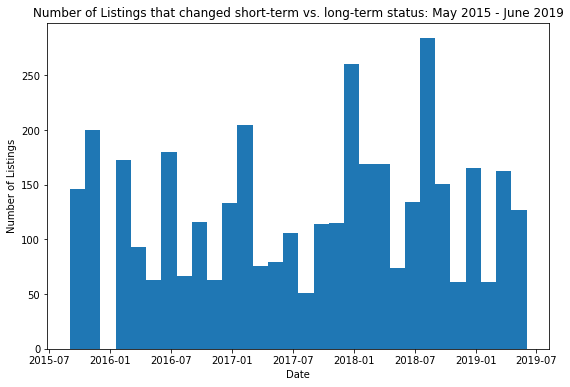

In [14]:
x = pd.to_datetime(chk_listings2['file_scraped_dt']).values
type(x)
x

plt.figure(figsize=(9,6))

plt.hist(x,bins=30)
plt.xlabel('Date')
plt.ylabel('Number of Listings')
plt.title('Number of Listings that changed short-term vs. long-term status: May 2015 - June 2019');



In [15]:
listings_t = listings_0.set_index(pd.DatetimeIndex(listings_0['file_scraped_dt']))
listings_t.shape

listings_short = listings_t[listings_t['short_term'] == 1]
listings_short.shape

listings_long = listings_t[listings_t['long_term'] == 1]
listings_long.shape


conn = sqlite3.connect("../data/airbnb.db")
ls = listings_short.drop('file_scraped_dt', axis = 1)
ls.to_sql('listings_shortterm_db', conn, if_exists='replace')


(342365, 110)

(292558, 110)

(49807, 110)

In [16]:
m_ls = listings_short.resample('D').size().reset_index(name='Counts') 

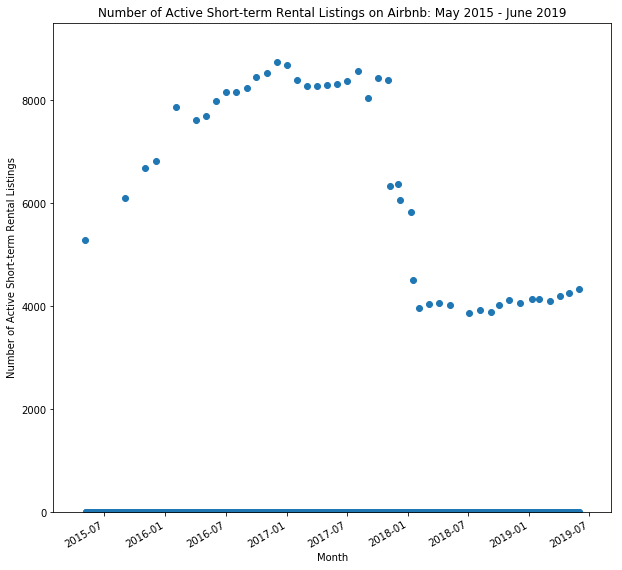

In [17]:
xlinspace = pd.date_range('2015-05-04', periods= m_ls.shape[0], freq='D')

fig, ax = plt.subplots(1,figsize = (10,10))
fig.autofmt_xdate()
plt.scatter(xlinspace,m_ls['Counts'])
ax.set_ylim(0,9500)
plt.xlabel("Month")
plt.ylabel("Number of Active Short-term Rental Listings")
plt.title("Number of Active Short-term Rental Listings on Airbnb: May 2015 - June 2019")

xfmt = mdates.DateFormatter('%m-%d-%y')
# ax.xaxis.set_major_formatter(xfmt)

plt.show();

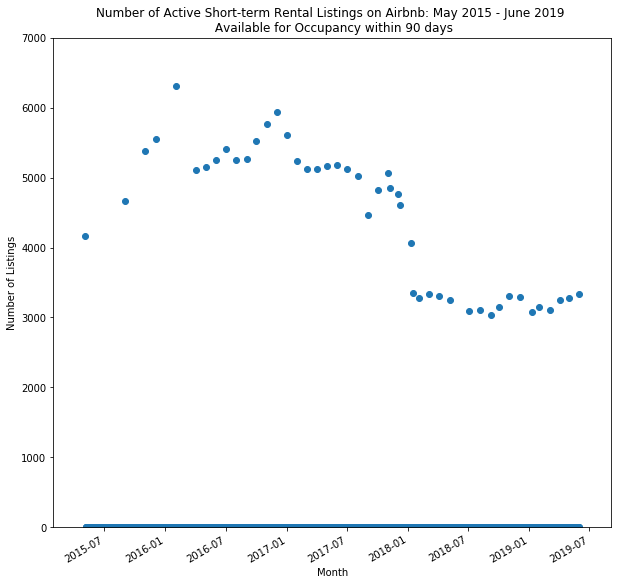

In [18]:
listings_short_avail = listings_short[listings_short['availability_90'] > 0]

m_ls_avail = listings_short_avail.resample('D').size().reset_index(name='Counts') 

xlinspace = pd.date_range('2015-05-04', periods= m_ls.shape[0], freq='D')

fig, ax = plt.subplots(1,figsize = (10,10))
fig.autofmt_xdate()
plt.scatter(xlinspace,m_ls_avail['Counts'])
ax.set_ylim(0,7000)
plt.xlabel("Month")
plt.ylabel("Number of Listings")
plt.title("Number of Active Short-term Rental Listings on Airbnb: May 2015 - June 2019 \n Available for Occupancy within 90 days")

xfmt = mdates.DateFormatter('%m-%d-%y')
# ax.xaxis.set_major_formatter(xfmt)

plt.show();

In [19]:
listings_short_avail.head(1)

id                       listing_url       scrape_id  \
file_scraped_dt                                                          
2019-06-02       958  https://www.airbnb.com/rooms/958  20190602163113   

                last_scraped                                 name  \
file_scraped_dt                                                     
2019-06-02        2019-06-02  Bright, Modern Garden Unit - 1BR/1B   

                                                           summary  \
file_scraped_dt                                                      
2019-06-02       New update: the house next door is under const...   

                                                             space  \
file_scraped_dt                                                      
2019-06-02       Newly remodeled, modern, and bright garden uni...   

                                                       description  \
file_scraped_dt                                                      
2019-06-02       New update: the house next door is under const...   

                experiences_offered  \
file_scraped_dt                       
2019-06-02                     none   

                                             neighborhood_overview  \
file_scraped_dt                                                      
2019-06-02       *Quiet cul de sac in friendly neighborhood *St...   

                     ...      require_guest_phone_verification  \
file_scraped_dt      ...                                         
2019-06-02           ...                                     f   

                calculated_host_listings_count  \
file_scraped_dt                                  
2019-06-02                                   1   

                calculated_host_listings_count_entire_homes  \
file_scraped_dt                                               
2019-06-02                                              1.0   

                calculated_host_listings_count_private_rooms  \
file_scraped_dt                                                
2019-06-02                                               0.0   

                calculated_host_listings_count_shared_rooms reviews_per_month  \
file_scraped_dt                                                                 
2019-06-02                                              0.0               1.6   

                short_term long_term file_scraped_dt  scraped_year  
file_scraped_dt                                                     
2019-06-02               1         0      2019-06-02          2019  

[1 rows x 110 columns]

In [20]:
# standardize property type

f = lambda x: 'BED & BREAKFAST' if x == 'BED AND BREAKFAST' else x

listings_t['property_type_c'] = listings_t['property_type'].str.upper().map(f)

In [21]:
# select a subset of fields in the Listings data. Use the standardized property_type.

sub = listings_t[['file_scraped_dt','scraped_year','id','host_since','host_id','property_type_c', 'room_type', 'minimum_nights', 'neighbourhood', 'review_scores_rating', 'review_scores_accuracy','review_scores_communication','review_scores_cleanliness','review_scores_location','review_scores_checkin','review_scores_value']]
sub.shape

(342365, 16)

In [22]:
del sub['file_scraped_dt']
sub.shape


(342365, 15)

In [23]:
# Initialize a sqlit3 database. Convert the 'sub' dataframe to a sql data table.


sub.to_sql('listings_all_db', conn, if_exists='replace')

In [24]:
# Convert the 'reviews' dataframe to a sql data table.

reviews.to_sql('reviews', conn, if_exists='replace')

In [25]:
# For any given listing, what's the first review date, last review date and number of reviews?


ls_reviews = pd.read_sql_query(
    'select listing_id, \
        min(date) as first_review_dt, \
        max(date) as last_review_dt, \
        count(*) as count_reviews \
        from reviews  \
        group by listing_id  \
        order by count_reviews desc;' ,conn)

# span of time between the first and last review dates in terms of months.

ls_reviews['reviews_history_month'] = (pd.to_datetime(ls_reviews['last_review_dt']) - pd.to_datetime(ls_reviews['first_review_dt']))/np.timedelta64(1, 'M')

ls_reviews.head()


listing_id first_review_dt last_review_dt  count_reviews  \
0      545685      2012-06-28     2019-05-30            741   
1        8739      2009-08-01     2019-05-21            715   
2      205842      2012-07-22     2019-01-01            674   
3     1920033      2013-11-22     2019-05-29            672   
4      585326      2012-07-14     2019-05-28            667   

   reviews_history_month  
0              83.024292  
1             117.620485  
2              77.340397  
3              66.169737  
4              82.432904

In [26]:
ls_reviews['reviews_history_month'].iplot(
    kind='hist',
    histnorm='percent',
  
    xTitle='Months',
    yTitle='(%) of Listings',
    title='Booking History of a Listing <br> Months Difference between the First Review Date and the Last Review Date')

In [27]:
ls_reviews['count_reviews'].iplot(
    kind='hist',
    histnorm='percent',
  
    xTitle='Number of Reviews',
    yTitle='(%) of Listings',
    title='Number of Reviews for a Listing')

In [28]:
plus5_reviews = ls_reviews[ls_reviews['count_reviews']>= 5]

plus5_reviews['count_reviews'].iplot(
    kind='hist',
    histnorm='percent',
  
    xTitle='Number of Reviews',
    yTitle='(%) of Listings',
    title='Number of Reviews for a Listing <br> Listings with a minimum of 5 reviews')

In [29]:
ls_reviews.to_sql('ls_reviews', conn, if_exists='replace')

In [30]:
tab1 = pd.read_sql_query(
    'select id as listing_id, property_type_c, room_type, host_since, \
        min(minimum_nights) as min_min_nights, \
        max(minimum_nights) as max_min_nights, \
        min(file_scraped_dt) as first_scraped_dt, \
        max(file_scraped_dt) as last_scraped_dt ,\
        count(1) as num_obs \
        from listings_all_db \
        group by listing_id;' ,conn)
tab1.head()

tab1.shape

chk_cnt = tab1['listing_id'].value_counts().reset_index(name = 'counts')
chk_cnt[chk_cnt['counts']> 1]

listing_id property_type_c        room_type  host_since  min_min_nights  \
0         958       APARTMENT  Entire home/apt  2008-07-31               1   
1        2822           HOUSE     Private room  2008-09-24               1   
2        3850           HOUSE     Private room  2008-12-08               1   
3        5021       APARTMENT  Entire home/apt  2009-01-29               1   
4        5193       APARTMENT  Entire home/apt  2009-02-05               1   

   max_min_nights     first_scraped_dt      last_scraped_dt  num_obs  
0               2  2015-05-04 00:00:00  2019-06-02 00:00:00       46  
1               1  2015-09-02 00:00:00  2016-06-02 00:00:00        7  
2               1  2015-05-04 00:00:00  2015-05-04 00:00:00        1  
3               1  2016-12-03 00:00:00  2018-01-17 00:00:00       12  
4              30  2015-05-04 00:00:00  2017-03-02 00:00:00       16

(29894, 9)

Empty DataFrame
Columns: [index, counts]
Index: []

In [31]:
tab1[tab1['num_obs'] <= 1].head()

listing_id property_type_c        room_type  host_since  min_min_nights  \
2         3850           HOUSE     Private room  2008-12-08               1   
8         6906       APARTMENT      Shared room  2009-05-08               1   
26       10840       APARTMENT  Entire home/apt  2009-09-15               3   
29       11319            None  Entire home/apt  2009-09-21               3   
43       16428       APARTMENT  Entire home/apt  2009-12-17               5   

    max_min_nights     first_scraped_dt      last_scraped_dt  num_obs  
2                1  2015-05-04 00:00:00  2015-05-04 00:00:00        1  
8                1  2016-10-01 00:00:00  2016-10-01 00:00:00        1  
26               3  2015-09-02 00:00:00  2015-09-02 00:00:00        1  
29               3  2015-05-04 00:00:00  2015-05-04 00:00:00        1  
43               5  2016-08-02 00:00:00  2016-08-02 00:00:00        1

In [32]:
# Checking if there is more than one property type associated with a given listing.

chk1 = tab1.groupby('listing_id')['property_type_c'].size().reset_index()
chk1[chk1['property_type_c'] > 1]



Empty DataFrame
Columns: [listing_id, property_type_c]
Index: []

In [33]:
# Checking if there is more than one room type associated with a given listing.

chk2 = tab1.groupby('listing_id')['room_type'].size().reset_index()
chk2[chk2['room_type'] > 1]



Empty DataFrame
Columns: [listing_id, room_type]
Index: []

In [34]:
tab1.to_sql('ls_dt_range', conn, if_exists='replace')


In [35]:
test = pd.read_sql_query(
    'select *, \
        (max_min_nights - min_min_nights) as diff_min_nights \
        from ls_dt_range \
        order by diff_min_nights desc;',conn)
test.head()




index  listing_id property_type_c        room_type  host_since  \
0  19256    15344978       APARTMENT     Private room  2008-06-25   
1  10364     8066789       APARTMENT     Private room  2011-10-14   
2  23282    19813606     CONDOMINIUM  Entire home/apt  2014-07-10   
3  24520    21483044      APARTHOTEL     Private room  2016-02-09   
4  10594     8184928       APARTMENT  Entire home/apt  2012-11-23   

   min_min_nights  max_min_nights     first_scraped_dt      last_scraped_dt  \
0               2       100000000  2017-02-02 00:00:00  2019-06-02 00:00:00   
1               2            1125  2015-09-02 00:00:00  2019-06-02 00:00:00   
2               1            1000  2017-08-02 00:00:00  2019-06-02 00:00:00   
3               1            1000  2017-11-01 00:00:00  2018-08-06 00:00:00   
4               1             999  2015-11-01 00:00:00  2019-06-02 00:00:00   

   num_obs  diff_min_nights  
0       23         99999998  
1       44             1123  
2       25              999  
3       12              999  
4       43              998

In [36]:
ls_tab = pd.read_sql_query(
    'select a.*, \
        b.first_review_dt, \
        b.last_review_dt,\
        b.count_reviews, \
        b.reviews_history_month \
        from ls_dt_range \
        as a \
        left join ls_reviews as b \
        on a.listing_id = b.listing_id',conn)

ls_tab.head()

index  listing_id property_type_c        room_type  host_since  \
0      0         958       APARTMENT  Entire home/apt  2008-07-31   
1      1        2822           HOUSE     Private room  2008-09-24   
2      2        3850           HOUSE     Private room  2008-12-08   
3      3        5021       APARTMENT  Entire home/apt  2009-01-29   
4      4        5193       APARTMENT  Entire home/apt  2009-02-05   

   min_min_nights  max_min_nights     first_scraped_dt      last_scraped_dt  \
0               1               2  2015-05-04 00:00:00  2019-06-02 00:00:00   
1               1               1  2015-09-02 00:00:00  2016-06-02 00:00:00   
2               1               1  2015-05-04 00:00:00  2015-05-04 00:00:00   
3               1               1  2016-12-03 00:00:00  2018-01-17 00:00:00   
4               1              30  2015-05-04 00:00:00  2017-03-02 00:00:00   

   num_obs first_review_dt last_review_dt  count_reviews  \
0       46      2009-07-23     2019-05-16          199.0   
1        7      2010-07-25     2016-05-08           55.0   
2        1      2009-07-16     2015-01-01          120.0   
3       12      2011-07-04     2017-12-31            6.0   
4       16      2009-09-29     2016-12-20          309.0   

   reviews_history_month  
0             117.751905  
1              69.455225  
2              65.545494  
3              77.931785  
4              86.704039

In [37]:
ls_tab['first_review_dt'].isnull().sum()

8683

In [38]:
chk =ls_tab[['listing_id','host_since', 'first_scraped_dt', 'last_scraped_dt','count_reviews', 'first_review_dt', 'last_review_dt']]

# it's problematic when the last review date is as long as several years after the last scraped date.

chk['chk_dt1'] = (pd.to_datetime(chk['last_review_dt']) - pd.to_datetime(chk['last_scraped_dt'])).dt.days
chk2 = chk[chk['chk_dt1'] > 0]
chk2.sort_values(by='chk_dt1',ascending = False).head(10)
chk3 = chk2[chk2['chk_dt1'] > 1000]
chk3.shape


# Presumably the listing is active long after the last booking.
chk.sort_values(by='chk_dt1').head(10)

Empty DataFrame
Columns: [listing_id, host_since, first_scraped_dt, last_scraped_dt, count_reviews, first_review_dt, last_review_dt, chk_dt1]
Index: []

(0, 8)

listing_id  host_since     first_scraped_dt      last_scraped_dt  \
134       44680  2010-08-09  2015-05-04 00:00:00  2019-06-02 00:00:00   
181       59831  2010-11-15  2018-08-06 00:00:00  2019-06-02 00:00:00   
221       71779  2011-01-30  2018-08-06 00:00:00  2019-06-02 00:00:00   
337      138681  2011-04-16  2017-01-01 00:00:00  2019-03-06 00:00:00   
563      261358  2011-10-06  2019-02-01 00:00:00  2019-06-02 00:00:00   
617      284811  2011-11-20  2019-01-09 00:00:00  2019-05-03 00:00:00   
119       41743  2010-07-27  2016-04-03 00:00:00  2017-11-01 00:00:00   
934      505763  2012-02-09  2018-08-06 00:00:00  2019-06-02 00:00:00   
944      511991  2011-06-20  2018-08-06 00:00:00  2019-06-02 00:00:00   
44        16551  2009-07-08  2015-05-04 00:00:00  2018-11-03 00:00:00   

     count_reviews first_review_dt last_review_dt  chk_dt1  
134            3.0      2010-08-20     2010-10-04  -3163.0  
181            1.0      2011-05-23     2011-05-23  -2932.0  
221            2.0      2011-08-02     2011-09-30  -2802.0  
337            2.0      2011-08-13     2011-08-23  -2752.0  
563            1.0      2011-11-23     2011-11-23  -2748.0  
617            1.0      2012-02-04     2012-02-04  -2645.0  
119            7.0      2010-08-01     2010-10-22  -2567.0  
934            8.0      2012-06-07     2012-07-03  -2525.0  
944            1.0      2012-09-14     2012-09-14  -2452.0  
44             7.0      2011-04-09     2012-04-23  -2385.0

In [39]:
# listings_to_chk.to_sql('listings_to_chk', conn, if_exists='replace')

# chk4 = pd.read_sql_query(
#     'select id as listing_id, property_type, room_type, host_since, \
#         min(minimum_nights) as min_min_nights, \
#         max(minimum_nights) as max_min_nights, \
#         min(file_scraped_dt) as first_scraped_dt, \
#         max(file_scraped_dt) as last_scraped_dt ,\
#         count(1) as num_obs \
#         from listings_to_chk \
#         group by listing_id;' ,conn)

# chk4.head()

In [40]:
# chk4[chk4['listing_id'] == 24390]

# listings_0[listings_0['id'] == 24390][['id', 'minimum_nights']]

# This example exposes the cause of the problem.

# some listings's minimum nights requirement change from less than 30 days to more than 30 days. When the data is filterd to 
# short-term rentals only, the observations where min. nights is equal or greater than 30 days are dropped. On the other hand, 
# since these listings remained active and we may observe review days/incidence of booking long after.

# several implications for this:

# 1. In the original Listings data, we shoul flag those listings of which the min. nights requirements changed.
# 2. Reviews are linked to listings by listing ID only, which means it's undistinguishbable whether the booking is for short-term 
# or long-term unless we further filter by time.

# When we chart the longevity of a listing, we should use the entire Listings data.

In [41]:
# for a given listing, days or months difference between the first review date (presumably start of the booking history)
# and the last scraped date

# If the last scraped date is prior to June 2 2019, then the listing has dropped out of the website.

# Since the most recent scraped date is June 2, 2019. It's unclear if a listing is going to be active or not in the next month. 


ls_tab['listing_month_diff'] = (pd.to_datetime(ls_tab['last_scraped_dt']) - pd.to_datetime(ls_tab['first_review_dt']))/np.timedelta64(1, 'M')
ls_tab['listing_day_diff'] = (pd.to_datetime(ls_tab['last_scraped_dt']) - pd.to_datetime(ls_tab['first_review_dt'])).dt.days


ls_tab['review_month_diff'] = (pd.to_datetime(ls_tab['last_review_dt']) - pd.to_datetime(ls_tab['first_review_dt']))/np.timedelta64(1, 'M')
ls_tab['review_day_diff'] = (pd.to_datetime(ls_tab['last_review_dt']) - pd.to_datetime(ls_tab['first_review_dt'])).dt.days

test = ls_tab[ls_tab['listing_day_diff']<0]
test.shape

ls_tab = ls_tab[ls_tab['listing_day_diff'] >=0]
ls_tab.shape


(0, 18)

(21211, 18)

In [42]:
ls_tab = ls_tab.sort_values(by='listing_month_diff')

ls_tab['last_scraped_year'] = pd.to_datetime(ls_tab['last_scraped_dt']).dt.year 
ls_tab['last_scraped_year'].value_counts()

2019    7159
2017    4676
2016    3446
2018    3444
2015    2486
Name: last_scraped_year, dtype: int64

In [43]:
# this includes both short-term and long-term

ls_tab2 = ls_tab[ls_tab['last_scraped_year'] <= 2017]
# ls_tab2[ls_tab2['listing_month_diff'] < 0]

ls_tab2[['listing_month_diff']].iplot(
    kind='hist',
#     histnorm='percent',
  
    xTitle='Months',
    yTitle='Number of Listings',
    title='Longevity of a Listing: up to December 2017 <br> Months Difference between the First Review Date and the Last Scraped Date')

In [44]:

ls_tab3 = ls_tab[ls_tab['last_scraped_year'] <= 2018]
ls_tab3.shape

ls_tab3[['listing_month_diff']].iplot(
    kind='hist',
#     histnorm='percent',
  
    xTitle='Months',
    yTitle='Number of Listings',
    title='Longevity of a Listing: up to December 2018 <br> Months Difference between the First Review Date and the Last Scraped Date')

(14052, 19)

In [45]:
scores = pd.read_sql_query(
    'select id as listing_id, \
        avg(review_scores_rating) as overall_scores, \
        avg(review_scores_accuracy) as accuracy_scores,\
        avg(review_scores_communication) as communication_scores,\
        avg(review_scores_cleanliness) as cleaniness_scores,\
        avg(review_scores_location) as location_scores,\
        avg(review_scores_checkin) as checkin_scores,\
        avg(review_scores_value) as value_scores \
        from listings_all_db  \
        where scraped_year <=2018 \
        group by listing_id order by overall_scores desc;',conn)

scores.head()




listing_id  overall_scores  accuracy_scores  communication_scores  \
0       11009           100.0             10.0                  10.0   
1       16428           100.0              9.0                  10.0   
2       24849           100.0             10.0                  10.0   
3       25094           100.0             10.0                  10.0   
4       25168           100.0             10.0                  10.0   

   cleaniness_scores  location_scores  checkin_scores  value_scores  
0               10.0             10.0         10.0000       10.0000  
1               10.0             10.0         10.0000       10.0000  
2               10.0             10.0         10.0000       10.0000  
3               10.0             10.0          9.9375        9.9375  
4               10.0             10.0         10.0000       10.0000

In [46]:
scores.to_sql('scores_db', conn, if_exists='replace')

In [47]:
ls_tab.columns

Index(['index', 'listing_id', 'property_type_c', 'room_type', 'host_since',
       'min_min_nights', 'max_min_nights', 'first_scraped_dt',
       'last_scraped_dt', 'num_obs', 'first_review_dt', 'last_review_dt',
       'count_reviews', 'reviews_history_month', 'listing_month_diff',
       'listing_day_diff', 'review_month_diff', 'review_day_diff',
       'last_scraped_year'],
      dtype='object')

In [48]:
ls_tab3.to_sql('ls_tab_db', conn, if_exists='replace')

scores_tab = pd.read_sql_query(
    'select a.*, \
        b.overall_scores, b.accuracy_scores,\
        b.communication_scores, b.cleaniness_scores,\
        b.location_scores, b.checkin_scores,b.value_scores \
        from ls_tab_db as a \
        left join scores_db as b \
        on a.listing_id = b.listing_id \
        where a.last_scraped_year = 2018',conn)

scores_tab.head()

level_0  index  listing_id property_type_c        room_type  host_since  \
0    27803  27803    29566422       APARTMENT  Entire home/apt  2018-10-25   
1    27774  27774    29487914         COTTAGE     Private room  2010-04-30   
2    27583  27583    28890997           HOUSE     Private room  2014-09-29   
3    27210  27210    27948187       APARTMENT  Entire home/apt  2016-12-16   
4    27800  27800    29554645     CONDOMINIUM  Entire home/apt  2012-08-16   

   min_min_nights  max_min_nights     first_scraped_dt      last_scraped_dt  \
0               1               1  2018-11-03 00:00:00  2018-11-03 00:00:00   
1               3               3  2018-11-03 00:00:00  2018-11-03 00:00:00   
2              30              30  2018-10-03 00:00:00  2018-10-03 00:00:00   
3              30              30  2018-09-08 00:00:00  2018-11-03 00:00:00   
4               3               3  2018-11-03 00:00:00  2018-11-03 00:00:00   

       ...       review_month_diff review_day_diff last_scraped_year  \
0      ...                     0.0             0.0              2018   
1      ...                     0.0             0.0              2018   
2      ...                     0.0             0.0              2018   
3      ...                     0.0             0.0              2018   
4      ...                     0.0             0.0              2018   

   overall_scores  accuracy_scores  communication_scores  cleaniness_scores  \
0             NaN              NaN                   NaN                NaN   
1             NaN              NaN                   NaN                NaN   
2            40.0              2.0                   4.0                2.0   
3            60.0              6.0                   4.0               10.0   
4             NaN              NaN                   NaN                NaN   

   location_scores  checkin_scores  value_scores  
0              NaN             NaN           NaN  
1              NaN             NaN           NaN  
2              4.0             2.0           4.0  
3              6.0             4.0           4.0  
4              NaN             NaN           NaN  

[5 rows x 27 columns]

In [49]:
scores_tab.drop('level_0', axis = 1).to_sql('listings_scores_db', conn, if_exists='replace')

In [50]:
# Relationship between longevity of a listing and scores

trace = go.Scatter(
    x = scores_tab['overall_scores'],
    y = scores_tab['listing_month_diff'],
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Overall Review Scores vs Longevity of a Listing <br> up to December 2018',
        xref='paper',
#         x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Average Review Scores',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Longevty of a Listing',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [51]:
# Relationship between number of reviews and length of booking history


trace = go.Scatter(
    x = ls_reviews['reviews_history_month'],
    y = ls_reviews['count_reviews'],
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Length of Booking History vs Number of Reviews <br> up to June 2019',
        xref='paper',
#         x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Approximation of Booking History in Months',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Number of Reviews',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

# Plot and embed in ipython notebook!
# py.iplot(data, xTitle = "Length of Booking History in Months", yTitle = "Number of Reviews")

In [52]:

trace = go.Scatter(
    x = scores_tab['listing_month_diff'],
    y = scores_tab['count_reviews'],
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Longevity of a Listing vs Number of Reviews <br> up to December 2018',
        xref='paper',
#         x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Longevity of a Listing in Months',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Number of Reviews',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [53]:
trace = go.Scatter(
    x = scores_tab['listing_month_diff'],
    y = scores_tab['review_month_diff'],
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Longevity of a Listing vs Approximation of Booking History <br> up to December 2018',
        xref='paper',
#         x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Longevity of a Listing in Months',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Approximation of Booking History in Months',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [54]:
# ls_tab_trunc = ls_tab[ls_tab['last_scraped_dt'] != '2019-05-03']
# ls_tab_trunc.head(1)

In [55]:

ls_tab3[['last_scraped_dt']].iplot(
    kind='hist',
#     histnorm='percent',
  
    xTitle='Months',
    yTitle='Number of Listings',
    title='Voluntary and Involuntary Attrition of Listings <br> up to December 2018')


# Some listngs may have legitimately disappeared as of May 2019. It's unknown unless the next month's scrape is available.

In [56]:
ls_tab3.head()

index  listing_id property_type_c        room_type  host_since  \
27803  27803    29566422       APARTMENT  Entire home/apt  2018-10-25   
19171  19171    15289877           HOUSE  Entire home/apt  2016-09-23   
17524  17524    13802856       APARTMENT     Private room  2016-04-21   
27774  27774    29487914         COTTAGE     Private room  2010-04-30   
27583  27583    28890997           HOUSE     Private room  2014-09-29   

       min_min_nights  max_min_nights     first_scraped_dt  \
27803               1               1  2018-11-03 00:00:00   
19171               1               1  2016-10-01 00:00:00   
17524               1               1  2016-07-02 00:00:00   
27774               3               3  2018-11-03 00:00:00   
27583              30              30  2018-10-03 00:00:00   

           last_scraped_dt  num_obs first_review_dt last_review_dt  \
27803  2018-11-03 00:00:00        1      2018-11-03     2018-11-03   
19171  2016-10-01 00:00:00        1      2016-10-01     2016-10-01   
17524  2016-07-02 00:00:00        1      2016-07-02     2016-07-02   
27774  2018-11-03 00:00:00        1      2018-11-02     2018-11-02   
27583  2018-10-03 00:00:00        1      2018-10-02     2018-10-02   

       count_reviews  reviews_history_month  listing_month_diff  \
27803            1.0                    0.0            0.000000   
19171            1.0                    0.0            0.000000   
17524            2.0                    0.0            0.000000   
27774            1.0                    0.0            0.032855   
27583            1.0                    0.0            0.032855   

       listing_day_diff  review_month_diff  review_day_diff  last_scraped_year  
27803               0.0                0.0              0.0               2018  
19171               0.0                0.0              0.0               2016  
17524               0.0                0.0              0.0               2016  
27774               1.0                0.0              0.0               2018  
27583               1.0                0.0              0.0               2018

In [57]:
# last listing date for a given host

tab2 = pd.read_sql_query(
    'select host_id, host_since, \
        max(file_scraped_dt) as last_scraped_dt, \
        max(scraped_year) as last_scraped_year \
        from listings_all_db \
        group by host_id \
        having last_scraped_year <= 2018;' ,conn)

tab2['host_month_diff'] = (pd.to_datetime(tab2['last_scraped_dt']) - pd.to_datetime(tab2['host_since']))/np.timedelta64(1, 'M')
tab2.head()

host_id  host_since      last_scraped_dt  last_scraped_year  \
0      240  2008-03-28  2016-06-02 00:00:00               2016   
1      254  2008-04-03  2015-05-04 00:00:00               2015   
2      316  2008-05-26  2017-05-02 00:00:00               2017   
3      322  2008-05-28  2016-04-03 00:00:00               2016   
4      426  2008-06-20  2016-11-02 00:00:00               2016   

   host_month_diff  
0        98.170394  
1        84.995585  
2       107.205487  
3        94.194953  
4       100.437381

In [58]:
# hosts could also be guests. when a host disappears from the website, does Airbnb lose a guest as well?

tab2[['host_month_diff']].iplot(
    kind='hist',
    histnorm='percent',
  
    xTitle='Months',
    yTitle='Percentage of Hosts',
    title='Longevity of a Host: up to December 2018 <br> Months Difference between Sign-up Date and the Last Scraped Date')

In [59]:
host_ls = pd.read_sql_query(
    'select host_id, \
        count(distinct(id)) as count_unique_listings \
        from listings_all_db \
        group by host_id \
        order by count_unique_listings desc;' ,conn)
host_ls.head(10)

host_id  count_unique_listings
0   48005494                    286
1  219930816                    198
2  107434423                    155
3   12243051                    130
4    4430421                     98
5  103340667                     83
6    1682188                     77
7      38836                     71
8   17042045                     69
9    7750221                     66

In [60]:
prop1 = pd.read_sql_query(
    'select room_type, count(*) as num  from ls_dt_range group by room_type;' ,conn)
prop1.head()

room_type    num
0  Entire home/apt  16895
1     Private room  11471
2      Shared room   1528

In [61]:
prop1 = pd.read_sql_query(
    'select count(*) as num  from ls_dt_range;' ,conn)
prop1.head()                    

num
0  29894

In [62]:
prop = pd.read_sql_query(
    'select id as listing_id, property_type_c, room_type from listings_all_db group by id;' ,conn)
prop.head()



listing_id property_type_c        room_type
0         958       APARTMENT  Entire home/apt
1        2822           HOUSE     Private room
2        3850           HOUSE     Private room
3        5021       APARTMENT  Entire home/apt
4        5193       APARTMENT  Entire home/apt

In [63]:
prop.to_sql('prop_room', conn, if_exists='replace')

In [64]:
entire_home = pd.read_sql_query(
    'select property_type_c,  count(*) as listing_count from prop_room where room_type = "Entire home/apt" group by property_type_c order by listing_count desc;' ,conn)
entire_home

property_type_c  listing_count
0            APARTMENT          10746
1                HOUSE           2963
2          CONDOMINIUM           1455
3          GUEST SUITE            621
4                 LOFT            314
5   SERVICED APARTMENT            162
6            TOWNHOUSE            157
7                OTHER            106
8           GUESTHOUSE             80
9       BOUTIQUE HOTEL             43
10           CAMPER/RV             38
11           TIMESHARE             35
12              IN-LAW             34
13            BUNGALOW             31
14                BOAT             28
15             COTTAGE             10
16        ENTIRE FLOOR             10
17               VILLA              8
18               CABIN              7
19                None              6
20     BED & BREAKFAST              6
21              CASTLE              5
22              RESORT              5
23                DORM              4
24                TENT              4
25                 BUS              3
26                YURT              3
27          TINY HOUSE              2
28          APARTHOTEL              1
29                BARN              1
30                CAVE              1
31              CHALET              1
32         EARTH HOUSE              1
33              HOSTEL              1
34               HOTEL              1
35                 HUT              1
36           TREEHOUSE              1

In [65]:
labels = list(entire_home['property_type_c'])
values = list(entire_home['listing_count']) 

trace = go.Pie(labels=labels, values=values)


data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Percentage of Listings by Property Type: Entire home/apartment only',
        xref='paper',

    ) 
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)




In [66]:
private_room = pd.read_sql_query(
    'select property_type_c,  count(*) as listing_count from prop_room where room_type = "Private room" group by property_type_c order by listing_count desc;' ,conn)
# private_room

labels = list(private_room['property_type_c'])
values = list(private_room['listing_count']) 

trace = go.Pie(labels=labels, values=values)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Percentage of Listings by Property Type: Private room only',
        xref='paper',

    ) 
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)


In [67]:
shared_room = pd.read_sql_query(
    'select property_type_c,  count(*) as listing_count from prop_room where room_type = "Shared room" group by property_type_c order by listing_count desc;' ,conn)
# shared_room

labels = list(shared_room['property_type_c'])
values = list(shared_room['listing_count']) 

trace = go.Pie(labels=labels, values=values)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Percentage of Listings by Property Type: Shared room only',
        xref='paper',

    ) 
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [68]:
room_type = pd.read_sql_query(
    'select room_type,  count(*) as listing_count from prop_room group by room_type;' ,conn)
room_type


labels = list(room_type['room_type'])
values = list(room_type['listing_count']) 

trace = go.Pie(labels=labels, values=values)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Percentage of Listings by Room Type',
        xref='paper',

    ) 
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)



# py.iplot([trace],title='Percentage of Listings by Room Type')

room_type  listing_count
0  Entire home/apt          16895
1     Private room          11471
2      Shared room           1528

In [69]:
crosstab = pd.crosstab(prop['property_type_c'].str.upper(), prop['room_type'])
crosstab.index

Index(['APARTHOTEL', 'APARTMENT', 'BARN', 'BED & BREAKFAST', 'BOAT',
       'BOUTIQUE HOTEL', 'BUNGALOW', 'BUS', 'CABIN', 'CAMPER/RV',
       'CASA PARTICULAR', 'CASTLE', 'CAVE', 'CHALET', 'CONDOMINIUM', 'COTTAGE',
       'DORM', 'EARTH HOUSE', 'ENTIRE FLOOR', 'GUEST SUITE', 'GUESTHOUSE',
       'HOSTEL', 'HOTEL', 'HOUSE', 'HUT', 'IN-LAW', 'ISLAND', 'LOFT', 'OTHER',
       'PENSION (KOREA)', 'PLANE', 'RESORT', 'SERVICED APARTMENT', 'TENT',
       'TIMESHARE', 'TINY HOUSE', 'TOWNHOUSE', 'TREEHOUSE', 'VACATION HOME',
       'VILLA', 'YURT'],
      dtype='object', name='property_type_c')

In [70]:
crosstab2 = crosstab[crosstab.index.isin(['APARTMENT', 'HOUSE', 'CONDOMINIUM'])].sort_values( by ='Entire home/apt', ascending = False)
crosstab2

room_type        Entire home/apt  Private room  Shared room
property_type_c                                            
APARTMENT                  10746          5770          621
HOUSE                       2963          3722          598
CONDOMINIUM                 1455           587           27

In [71]:
trace1 = go.Bar(
    x=  crosstab2.index,
    y=  list(crosstab2['Entire home/apt']),
    name='Entire home/apartment'
)
trace2 = go.Bar(
    x= crosstab2.index,
    y= list(crosstab2['Private room']),
    name='Private room'
)

trace3 = go.Bar(
    x= crosstab2.index,
    y= list(crosstab2['Shared room']),
    name='Shared room'
)


data = [trace1, trace2,trace3]
layout = go.Layout(
    barmode='stack', title=go.layout.Title(
        text='Mix of Room Type per Property Type',
#         xref='paper',
    ),
     yaxis=dict(
        title='Number of Listings'),
    
    xaxis=dict(
        title = 'Property Type')
    
    

)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [72]:
# host_id	count_unique_listings
# 0	17042045	69
# 1	7750221	66
# 2	173206762	65
# 3	64646820	64
# 4	118412894	53

In [73]:
# test = listings[listings['host_id'] == 17042045]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# test.property_type.value_counts()

# # The host with the largest number of listings is the Bartlett, "a cross between a hostel and a bare minimum hotel"

In [74]:
# test = listings_t[listings_t['host_id'] == 7750221]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# test.property_type.value_counts()
# # second one is Branson Hacker Coliving.

In [75]:
# test = listings[listings['host_id'] == 173206762]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# test.property_type.value_counts()

# # Number 3 is Stratford Hotel.


In [76]:
# test = listings[listings['host_id'] == 64646820]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# #Number four is a boutique hotel, run by a host who operates time share in multiple cities!

# test.property_type.value_counts()


In [77]:
# test = listings_t[listings_t['host_id'] == 118412894]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# test.property_type.value_counts()
# Number five is a boutique hotel.


In [78]:
# The top 5 hosts in terms of number of unique short-term rental listings appear to be either boutique hotels or 
# hacker coliving. Several of them have ceased to operate on Airbnb.



In [79]:
def generateBaseMap(default_location=[37.76931, -122.43386], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [80]:
entire_home = listings_short_avail[listings_short_avail['room_type'] == "Entire home/apt"]
entire_home['counter'] = 1

scraped_dt_list = []
for dt in entire_home.file_scraped_dt.sort_values().unique():
    scraped_dt_list.append(entire_home.loc[entire_home.file_scraped_dt == dt, ['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())

In [81]:
base_map = generateBaseMap()
HeatMapWithTime(scraped_dt_list, radius=3, gradient={0.8: 'blue'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map.save('shortterm_entirehome_heatmap.html')



In [82]:
private_room = listings_short_avail[listings_short_avail['room_type'] == "Private room"]
private_room['counter'] = 1

scraped_dt_list = []
for dt in private_room.file_scraped_dt.sort_values().unique():
    scraped_dt_list.append(private_room.loc[private_room.file_scraped_dt == dt, ['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
    
base_map = generateBaseMap()
HeatMapWithTime(scraped_dt_list, radius=3, gradient={0.8: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map.save('shortterm_privateroom_heatmap.html')

In [83]:
# private_room_long = listings_long[listings_long['room_type'] == "Private room"]
# private_room_long['counter'] = 1

# scraped_dt_list = []
# for dt in private_room_long.file_scraped_dt.sort_values().unique():
#     scraped_dt_list.append(private_room_long.loc[private_room_long.file_scraped_dt == dt, ['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
    
# base_map = generateBaseMap()
# HeatMapWithTime(scraped_dt_list, radius=3, gradient={0.8: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
# base_map.save('longterm_privateroom_heatmap.html')

In [84]:
# entire_home_long = listings_long[listings_long['room_type'] == "Entire home/apt"]
# entire_home_long['counter'] = 1

# scraped_dt_list = []
# for dt in entire_home_long.file_scraped_dt.sort_values().unique():
#     scraped_dt_list.append(entire_home_long.loc[entire_home_long.file_scraped_dt == dt, ['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
    
# base_map = generateBaseMap()
# HeatMapWithTime(scraped_dt_list, radius=3, gradient={0.8: 'blue'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
# base_map.save('longterm_entirehome_heatmap.html')

In [85]:
# entire_home_long['file_scraped_dt'].value_counts().reset_index().head()

In [86]:
# private_room_long['file_scraped_dt'].value_counts().reset_index().head()

In [87]:
# dt_lst = sorted(list(listings_short['file_scraped_dt'].unique()))
# for k, dt in enumerate(dt_lst):
#     print(k, dt)

In [88]:
# Static heatmap for Nov-1 2017 to Feb-2 2018

# for dt in dt_lst[24:31]:
#     dat = entire_home[entire_home['file_scraped_dt'] == dt]
#     base_map = generateBaseMap()
#     HeatMap(data=dat[['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=3, gradient={0.8: 'blue'}).add_to(base_map)
#     base_map.save('entirehome_heatmap{}.html'.format(str(dt)))

In [89]:
listings_short_avail.groupby('neighbourhood_cleansed').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

neighbourhood_cleansed  counts
16                Mission   23077
36       Western Addition   16563
31        South of Market   12920
2     Castro/Upper Market   12045
1          Bernal Heights   11363
6   Downtown/Civic Center   10542
18             Noe Valley    9629
11         Haight Ashbury    9492
23           Outer Sunset    8296
26           Potrero Hill    6811
12         Inner Richmond    6781
15                 Marina    6553
17               Nob Hill    5557
22         Outer Richmond    5034
21          Outer Mission    4918
24        Pacific Heights    4860
29           Russian Hill    4602
19            North Beach    4165
7               Excelsior    4050
13           Inner Sunset    4031
25               Parkside    3952
0                 Bayview    3901
35     West of Twin Peaks    3800
20             Ocean View    3453
8      Financial District    3199
3               Chinatown    2285
33             Twin Peaks    2271
9               Glen Park    2164
34      Visitacion Valley    1778
14              Lakeshore    1537
4          Crocker Amazon    1254
28       Presidio Heights     916
5         Diamond Heights     587
30               Seacliff     578
10       Golden Gate Park     342
32    Treasure Island/YBI     280
27               Presidio     128

In [90]:
ls_by_nb = listings_short_avail.groupby(['neighbourhood_cleansed', 'file_scraped_dt']).size().reset_index(name='counts')
ls_by_nb.head()

C:\Users\ksher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

'file_scraped_dt' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



neighbourhood_cleansed file_scraped_dt  counts
0                Bayview      2015-05-04      55
1                Bayview      2015-09-02      59
2                Bayview      2015-11-01      71
3                Bayview      2015-12-02      76
4                Bayview      2016-02-02      97

In [91]:
ls_by_nb['lagged_counts'] = ls_by_nb.groupby(['neighbourhood_cleansed'])['counts'].transform(lambda x:x.shift(1))
ls_by_nb['pct_change'] = ((ls_by_nb['counts'] - ls_by_nb['lagged_counts'])/ls_by_nb['lagged_counts']) * 100
ls_by_nb.head()

neighbourhood_cleansed file_scraped_dt  counts  lagged_counts  pct_change
0                Bayview      2015-05-04      55            NaN         NaN
1                Bayview      2015-09-02      59           55.0    7.272727
2                Bayview      2015-11-01      71           59.0   20.338983
3                Bayview      2015-12-02      76           71.0    7.042254
4                Bayview      2016-02-02      97           76.0   27.631579

In [92]:
ls_by_nb[ls_by_nb['neighbourhood_cleansed'] == 'South of Market'] 

neighbourhood_cleansed file_scraped_dt  counts  lagged_counts  pct_change
1426        South of Market      2015-05-04     303            NaN         NaN
1427        South of Market      2015-09-02     369          303.0   21.782178
1428        South of Market      2015-11-01     408          369.0   10.569106
1429        South of Market      2015-12-02     416          408.0    1.960784
1430        South of Market      2016-02-02     545          416.0   31.009615
1431        South of Market      2016-04-03     389          545.0  -28.623853
1432        South of Market      2016-05-02     408          389.0    4.884319
1433        South of Market      2016-06-02     402          408.0   -1.470588
1434        South of Market      2016-07-02     441          402.0    9.701493
1435        South of Market      2016-08-02     419          441.0   -4.988662
1436        South of Market      2016-09-02     429          419.0    2.386635
1437        South of Market      2016-10-01     399          429.0   -6.993007
1438        South of Market      2016-11-02     406          399.0    1.754386
1439        South of Market      2016-12-03     442          406.0    8.866995
1440        South of Market      2017-01-01     415          442.0   -6.108597
1441        South of Market      2017-02-02     361          415.0  -13.012048
1442        South of Market      2017-03-02     358          361.0   -0.831025
1443        South of Market      2017-04-02     344          358.0   -3.910615
1444        South of Market      2017-05-02     352          344.0    2.325581
1445        South of Market      2017-06-02     352          352.0    0.000000
1446        South of Market      2017-07-02     335          352.0   -4.829545
1447        South of Market      2017-08-02     324          335.0   -3.283582
1448        South of Market      2017-09-02     284          324.0  -12.345679
1449        South of Market      2017-10-02     327          284.0   15.140845
1450        South of Market      2017-11-01     338          327.0    3.363914
1451        South of Market      2017-11-08     323          338.0   -4.437870
1452        South of Market      2017-12-02     299          323.0   -7.430341
1453        South of Market      2017-12-07     278          299.0   -7.023411
1454        South of Market      2018-01-10     241          278.0  -13.309353
1455        South of Market      2018-01-17     172          241.0  -28.630705
1456        South of Market      2018-02-02     142          172.0  -17.441860
1457        South of Market      2018-03-04     162          142.0   14.084507
1458        South of Market      2018-04-06     115          162.0  -29.012346
1459        South of Market      2018-05-09     120          115.0    4.347826
1460        South of Market      2018-07-05     112          120.0   -6.666667
1461        South of Market      2018-08-06     114          112.0    1.785714
1462        South of Market      2018-09-08     102          114.0  -10.526316
1463        South of Market      2018-10-03     115          102.0   12.745098
1464        South of Market      2018-11-03     125          115.0    8.695652
1465        South of Market      2018-12-06     125          125.0    0.000000
1466        South of Market      2019-01-09     116          125.0   -7.200000
1467        South of Market      2019-02-01     125          116.0    7.758621
1468        South of Market      2019-03-06     131          125.0    4.800000
1469        South of Market      2019-04-03     138          131.0    5.343511
1470        South of Market      2019-05-03     145          138.0    5.072464
1471        South of Market      2019-06-02     154          145.0    6.206897

In [93]:
ls_by_nb[ls_by_nb['neighbourhood_cleansed'] == 'Chinatown'] 

neighbourhood_cleansed file_scraped_dt  counts  lagged_counts  pct_change
138              Chinatown      2015-05-04      45            NaN         NaN
139              Chinatown      2015-09-02      40           45.0  -11.111111
140              Chinatown      2015-11-01      51           40.0   27.500000
141              Chinatown      2015-12-02      57           51.0   11.764706
142              Chinatown      2016-02-02      78           57.0   36.842105
143              Chinatown      2016-04-03      61           78.0  -21.794872
144              Chinatown      2016-05-02      59           61.0   -3.278689
145              Chinatown      2016-06-02      46           59.0  -22.033898
146              Chinatown      2016-07-02      59           46.0   28.260870
147              Chinatown      2016-08-02      58           59.0   -1.694915
148              Chinatown      2016-09-02      64           58.0   10.344828
149              Chinatown      2016-10-01      86           64.0   34.375000
150              Chinatown      2016-11-02      84           86.0   -2.325581
151              Chinatown      2016-12-03     106           84.0   26.190476
152              Chinatown      2017-01-01     101          106.0   -4.716981
153              Chinatown      2017-02-02      75          101.0  -25.742574
154              Chinatown      2017-03-02      80           75.0    6.666667
155              Chinatown      2017-04-02      72           80.0  -10.000000
156              Chinatown      2017-05-02      76           72.0    5.555556
157              Chinatown      2017-06-02      72           76.0   -5.263158
158              Chinatown      2017-07-02      70           72.0   -2.777778
159              Chinatown      2017-08-02      75           70.0    7.142857
160              Chinatown      2017-09-02      54           75.0  -28.000000
161              Chinatown      2017-10-02      60           54.0   11.111111
162              Chinatown      2017-11-01      67           60.0   11.666667
163              Chinatown      2017-11-08      59           67.0  -11.940299
164              Chinatown      2017-12-02      63           59.0    6.779661
165              Chinatown      2017-12-07      69           63.0    9.523810
166              Chinatown      2018-01-10      38           69.0  -44.927536
167              Chinatown      2018-01-17      20           38.0  -47.368421
168              Chinatown      2018-02-02      19           20.0   -5.000000
169              Chinatown      2018-03-04      17           19.0  -10.526316
170              Chinatown      2018-04-06      18           17.0    5.882353
171              Chinatown      2018-05-09      20           18.0   11.111111
172              Chinatown      2018-07-05      19           20.0   -5.000000
173              Chinatown      2018-08-06      28           19.0   47.368421
174              Chinatown      2018-09-08      20           28.0  -28.571429
175              Chinatown      2018-10-03      21           20.0    5.000000
176              Chinatown      2018-11-03      25           21.0   19.047619
177              Chinatown      2018-12-06      23           25.0   -8.000000
178              Chinatown      2019-01-09      21           23.0   -8.695652
179              Chinatown      2019-02-01      20           21.0   -4.761905
180              Chinatown      2019-03-06      21           20.0    5.000000
181              Chinatown      2019-04-03      23           21.0    9.523810
182              Chinatown      2019-05-03      22           23.0   -4.347826
183              Chinatown      2019-06-02      23           22.0    4.545455

In [94]:
ls_by_nb.pivot(values = 'pct_change', columns = 'neighbourhood_cleansed', index='file_scraped_dt')

# The number of listings went up a lot in August 2018 across multiple neighborhoods.

neighbourhood_cleansed    Bayview  Bernal Heights  Castro/Upper Market  \
file_scraped_dt                                                          
2015-05-04                    NaN             NaN                  NaN   
2015-09-02               7.272727        2.212389            17.307692   
2015-11-01              20.338983       15.151515            19.016393   
2015-12-02               7.042254        3.383459            -1.101928   
2016-02-02              27.631579       12.000000            10.306407   
2016-04-03             -13.402062      -13.636364           -17.424242   
2016-05-02               3.571429        0.000000            -1.223242   
2016-06-02              -4.597701        4.887218            -3.715170   
2016-07-02               1.204819        2.508961             1.929260   
2016-08-02               0.000000       -3.846154            -3.154574   
2016-09-02              -7.142857        0.000000            -6.840391   
2016-10-01              11.538462        6.545455             8.741259   
2016-11-02               2.298851        3.071672             7.395498   
2016-12-03               6.741573        3.973510            -0.598802   
2017-01-01              -9.473684      -10.509554            -5.120482   
2017-02-02              -4.651163        1.067616            -7.301587   
2017-03-02              -7.317073       -4.225352            -1.712329   
2017-04-02               9.210526       -1.470588            -3.135889   
2017-05-02               4.819277        3.731343             0.359712   
2017-06-02              10.344828        0.359712             2.508961   
2017-07-02               0.000000        3.942652             3.146853   
2017-08-02              -1.041667       -5.172414            -3.728814   
2017-09-02              -6.315789       -8.727273           -10.563380   
2017-10-02               7.865169        6.374502            11.811024   
2017-11-01              12.500000        3.370787            -0.704225   
2017-11-08              -6.481481       -3.260870            -1.418440   
2017-12-02               0.990099       -8.239700            -7.913669   
2017-12-07              -7.843137        2.448980            -2.734375   
2018-01-10               1.063830       -7.968127           -14.859438   
2018-01-17              -7.368421       -8.225108           -16.037736   
2018-02-02              -1.136364      -11.320755             2.808989   
2018-03-04               6.896552        5.319149             7.650273   
2018-04-06              -3.225806        0.505051            -3.553299   
2018-05-09             -16.666667        6.532663             7.368421   
2018-07-05              -6.666667       -1.886792            -1.470588   
2018-08-06               8.571429       -2.884615             1.492537   
2018-09-08             -13.157895       -7.920792            -3.921569   
2018-10-03               7.575758        8.602151             1.530612   
2018-11-03              15.492958       10.891089             4.522613   
2018-12-06              -8.536585        3.571429            -1.442308   
2019-01-09               9.333333      -13.362069            -6.829268   
2019-02-01               1.219512        1.492537             4.188482   
2019-03-06              -8.433735       -6.862745            -2.010050   
2019-04-03              15.789474        6.842105             6.153846   
2019-05-03               5.681818        0.000000             3.381643   
2019-06-02              -2.150538        9.359606            -0.934579   

neighbourhood_cleansed  Chinatown  Crocker Amazon  Diamond Heights  \
file_scraped_dt                                                      
2015-05-04                    NaN             NaN              NaN   
2015-09-02             -11.111111      -34.615385        33.333333   
2015-11-01              27.500000       29.411765        16.666667   
2015-12-02              11.764706        4.545455        -7.142857   
2016-02-02              36.

In [95]:
# neighborhoods = pd.read_sql_query(
#     'select file_scraped_dt,\
#         upper(neighbourhood_cleansed) as neighbourhood,\
#         count(*) as count_listings \
#         from listings_shortterm_db \
#         group by file_scraped_dt, neighbourhood \
#         order by file_scraped_dt, count_listings desc;' ,conn)
# # neighborhoods['dt'] = pd.to_datetime(neighborhoods['file_scraped_dt'])

# neighborhoods.head()

In [96]:
# test = ls_by_nb.pivot(values = 'counts', columns = 'neighbourhood_cleansed', index='file_scraped_dt')

test2 = ls_by_nb[ls_by_nb['neighbourhood_cleansed'].isin(['Mission', 'South of Market','Financial District', 'Western Addition', 'Downtown/Civic Center', 'Pacific Heights'])]

# sns.lineplot(x = 'file_scraped_dt', y)

Text(0.5, 1.0, 'Monthly Supply of Short-term Rental Listings in Selected SF Neighborhood \n Available for Occupancy within 90 Days')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of Listings')

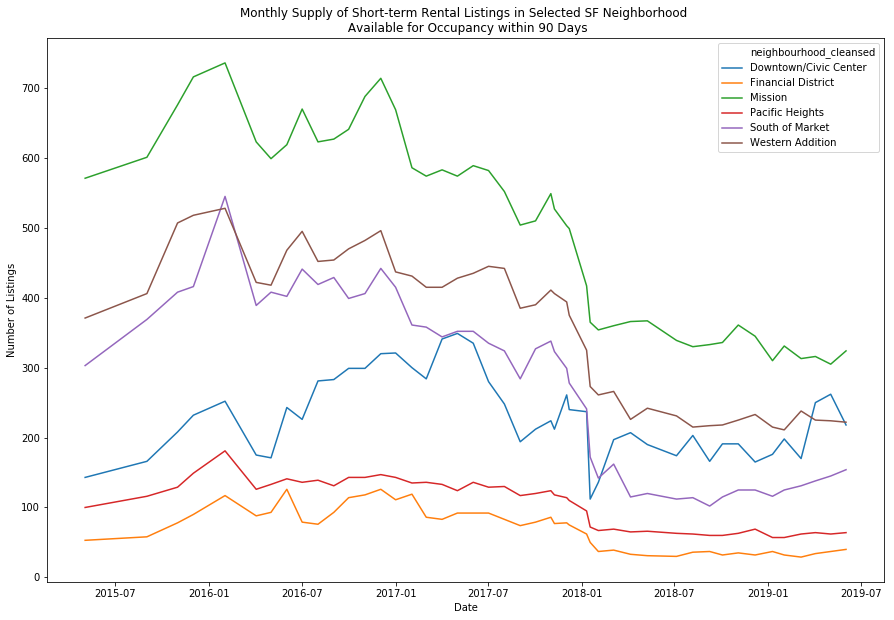

In [97]:
fig, ax = plt.subplots(1,1,figsize = (15,10))

sns.lineplot(x= 'file_scraped_dt', y='counts', hue = 'neighbourhood_cleansed', data = test2)
plt.title("Monthly Supply of Short-term Rental Listings in Selected SF Neighborhood \n Available for Occupancy within 90 Days")
plt.xlabel("Date")
plt.ylabel("Number of Listings")

In [98]:
listing_nb = pd.read_sql_query(
    'select id as listing_id, \
        neighbourhood_cleansed, \
        count(*) as cnt \
        from listings_shortterm_db  \
        group by listing_id,neighbourhood_cleansed  ;' ,conn)



In [99]:
tmp = listing_nb.pivot(values = 'cnt', columns = 'neighbourhood_cleansed', index = 'listing_id')

tmp['std_nb'] = tmp.idxmax(axis=1)
tmp2 = tmp[['std_nb']]
tmp2.reset_index(level=0, inplace=True)

# tmp2.to_sql('listing_loc_db', conn, if_exists='replace')

pickle.dump(tmp2, open('../data/listings_loc.p','wb'))

In [100]:
# neighborhoods.pivot(values='count_listings', columns='neighbourhood')

In [101]:
# neighborhoods['year'] = pd.to_datetime(neighborhoods['file_scraped_dt']).dt.year
# neighborhoods['month'] = pd.to_datetime(neighborhoods['file_scraped_dt']).dt.month
# neighborhoods['date'] = pd.to_datetime(neighborhoods['file_scraped_dt']).dt.day

# neighborhoods.groupby(['year','month','date']).size()

# pd.to_datetime(neighborhoods['file_scraped_dt']).value_counts().reset_index()

# neighborhoods['file_scraped_dt'].unique()

# nbh_Nov2017_01 = neighborhoods[neighborhoods['file_scraped_dt'] == '2017-11-01']




In [102]:

# colors = 5
# cmap = 'Blues'
# figsize = (16, 10)


# file = 'neighbourhoods.geojson'
# geo = gpd.read_file(file,index=None)
# geo['neighbourhood'] = geo['neighbourhood'].str.upper()


# merged = geo.merge(neighborhoods, left_on='neighbourhood', right_on='neighbourhood')


# ax = merged[merged['file_scraped_dt'] == '2017-11-01'].dropna().plot(column='count_listings', cmap = cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)

# merged.plot(ax=ax, color='#fafafa', hatch='///')

# ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
# ax.annotate(description, xy=(0.1, 0.1), size=12, xycoords='figure fraction')

# ax.set_axis_off()
# ax.set_xlim([-1.5e7, 1.7e7])
# ax.get_legend().set_bbox_to_anchor((.12, .4))
# ax.get_figure()

# base_map = generateBaseMap()
# folium.GeoJson(json.load(open(file)),name='geojson').add_to(base_map)
# # folium.GeoJson(file,name='geojson').add_to(map)
# base_map
# # folium.LayerControl().add_to(map)
# # map.save("folium_map.html")

# # dt_lst = ['2017-10-02', '2017-11-01', '2017-11-08', '2017-12-02', '2017-12-07','2018-01-10', '2018-01-17', '2018-02-02']

# # for dt in dt_lst:
# base_map.choropleth(
#      geo_data=geo,
#      name='choropleth',
#      data=neighborhoods[neighborhoods['file_scraped_dt'] == '2017-11-01'],
#      columns=['neighbourhood', 'count_listings'],
#      key_on='properties.neighbourhood',
#      fill_color='YlGn',
#      fill_opacity=0.7,
#      line_opacity=0.2,
#      legend_name='Number of Listings'
#     )
# folium.LayerControl().add_to(base_map)

#     # Save to html
# base_map.save('chloropleth_2017-11-01.html')


In [103]:
# with open('neighbourhoods.geojson') as f:
#     js = json.load(f)


In [104]:
# js['features'][0]['properties']

In [105]:
# listings_short['pt_shapely'] = Point(np.array((listings_short.iloc[i]['longitude'],listings_short.iloc[i]['latitude'])))
# listings_short.head(1)

In [106]:
# neighborhoods = []

# for i in range(len(listings_short)):
#     pt = Point(np.array((listings_short.iloc[i]['longitude'],listings_short.iloc[i]['latitude'])))
#     filter = geo['geometry'].contains(pt)
#     nh = (geo.loc[filter, 'neighbourhood'])
#     neighborhoods.append(nh)             

In [107]:
# nh_cleaned = []
# for k in neighborhoods[0:10]:
#     print(k)
# #     re.sub(r'\d+', '', k)
    
# # len(nh_cleaned)   


In [108]:
# pd.DataFrame(neighborhoods)

In [109]:
# listings_short['coord'] = Point(listings_short['longitude'], listings_short['latitude'])
# listings_short['zip_code_std'] = listings_short['coord'].map(find_neighborhood)
# X=[]
# for i in range(0,len(df)):
#     pt=Point(df.iloc[i][21],df.iloc[i][20])
#     a=find_neighborhood(js=js,point=pt)
#     X.append(a)
    
    
# listings_short[['latitude', 'longitude']]

# latitude', 'longitude',


# X=[]
# for i in range(0,len(listings_short)):
#     pt=Point(listings_short.iloc[i]['longitude'],listings_short.iloc[i]['latitude'])
#     a= find_neighborhood(pt)
#     X.append(a)
    

In [110]:
dt_lst = sorted(list(listings_0['file_scraped_dt'].unique()))

In [111]:
for k, dt in enumerate(dt_lst):
    print(k+1, dt)

1 2015-05-04T00:00:00.000000000
2 2015-09-02T00:00:00.000000000
3 2015-11-01T00:00:00.000000000
4 2015-12-02T00:00:00.000000000
5 2016-02-02T00:00:00.000000000
6 2016-04-03T00:00:00.000000000
7 2016-05-02T00:00:00.000000000
8 2016-06-02T00:00:00.000000000
9 2016-07-02T00:00:00.000000000
10 2016-08-02T00:00:00.000000000
11 2016-09-02T00:00:00.000000000
12 2016-10-01T00:00:00.000000000
13 2016-11-02T00:00:00.000000000
14 2016-12-03T00:00:00.000000000
15 2017-01-01T00:00:00.000000000
16 2017-02-02T00:00:00.000000000
17 2017-03-02T00:00:00.000000000
18 2017-04-02T00:00:00.000000000
19 2017-05-02T00:00:00.000000000
20 2017-06-02T00:00:00.000000000
21 2017-07-02T00:00:00.000000000
22 2017-08-02T00:00:00.000000000
23 2017-09-02T00:00:00.000000000
24 2017-10-02T00:00:00.000000000
25 2017-11-01T00:00:00.000000000
26 2017-11-08T00:00:00.000000000
27 2017-12-02T00:00:00.000000000
28 2017-12-07T00:00:00.000000000
29 2018-01-10T00:00:00.000000000
30 2018-01-17T00:00:00.000000000
31 2018-02-02T00:00

In [112]:
m_ls[m_ls['Counts']>0]

file_scraped_dt  Counts
0         2015-05-04    5280
121       2015-09-02    6102
181       2015-11-01    6684
212       2015-12-02    6823
274       2016-02-02    7873
335       2016-04-03    7608
364       2016-05-02    7686
395       2016-06-02    7973
425       2016-07-02    8147
456       2016-08-02    8155
487       2016-09-02    8224
516       2016-10-01    8448
548       2016-11-02    8530
579       2016-12-03    8735
608       2017-01-01    8684
640       2017-02-02    8389
668       2017-03-02    8272
699       2017-04-02    8265
729       2017-05-02    8297
760       2017-06-02    8319
790       2017-07-02    8378
821       2017-08-02    8567
852       2017-09-02    8041
882       2017-10-02    8437
912       2017-11-01    8394
919       2017-11-08    6326
943       2017-12-02    6371
948       2017-12-07    6056
982       2018-01-10    5837
989       2018-01-17    4505
1005      2018-02-02    3961
1035      2018-03-04    4051
1068      2018-04-06    4065
1101      2018-05-09    4018
1158      2018-07-05    3873
1190      2018-08-06    3925
1223      2018-09-08    3892
1248      2018-10-03    4028
1279      2018-11-03    4118
1312      2018-12-06    4055
1346      2019-01-09    4131
1369      2019-02-01    4147
1402      2019-03-06    4096
1430      2019-04-03    4196
1460      2019-05-03    4253
1490      2019-06-02    4343

In [113]:
# listings_short['price_decimal'] = listings_short['price'].apply(lambda x: Decimal(sub(r'[^\d.]', '', x)))

# listings_short['price_float'] = listings_short['price_decimal'].apply(lambda x: float(x))

listings_short_avail['price_float'] = listings_short_avail['price'].str.replace("\$|,", "").astype(float)
listings_short_avail.head()

id                        listing_url       scrape_id  \
file_scraped_dt                                                            
2019-06-02        958   https://www.airbnb.com/rooms/958  20190602163113   
2019-06-02       8339  https://www.airbnb.com/rooms/8339  20190602163113   
2019-06-02       8567  https://www.airbnb.com/rooms/8567  20190602163113   
2019-06-02       8739  https://www.airbnb.com/rooms/8739  20190602163113   
2019-06-02       9225  https://www.airbnb.com/rooms/9225  20190602163113   

                last_scraped                                       name  \
file_scraped_dt                                                           
2019-06-02        2019-06-02        Bright, Modern Garden Unit - 1BR/1B   
2019-06-02        2019-06-02            Historic Alamo Square Victorian   
2019-06-02        2019-06-02             Lovely 2BR flat Great Location   
2019-06-02        2019-06-02        Mission Sunshine, with Private Bath   
2019-06-02        2019-06-02  Artful Potrero Separate Floor with Garden   

                                                           summary  \
file_scraped_dt                                                      
2019-06-02       New update: the house next door is under const...   
2019-06-02       Pls email before booking.  Interior featured i...   
2019-06-02                                                     NaN   
2019-06-02       Welcome to "The Mission," the sunniest neighbo...   
2019-06-02       A Unique Guest Suite! A Spacious  Art Filled  ...   

                                                             space  \
file_scraped_dt                                                      
2019-06-02       Newly remodeled, modern, and bright garden uni...   
2019-06-02       Please send us a quick message before booking ...   
2019-06-02       Fully furnished 2BR, 1BA flat in beautiful Vic...   
2019-06-02       Your sunny room looks out over a lush garden, ...   
2019-06-02       It is unique, very spacious  [800 sq. ft. with...   

                                                       description  \
file_scraped_dt                                                      
2019-06-02       New update: the house next door is under const...   
2019-06-02       Pls email before booking.  Interior featured i...   
2019-06-02       Fully furnished 2BR, 1BA flat in beautiful Vic...   
2019-06-02       Welcome to "The Mission," the sunniest neighbo...   
2019-06-02       A Unique Guest Suite! A Spacious  Art Filled  ...   

                experiences_offered  \
file_scraped_dt                       
2019-06-02                     none   
2019-06-02                     none   
2019-06-02                     none   
2019-06-02                     none   
2019-06-02                     none   

                                             neighborhood_overview  \
file_scraped_dt                                                      
2019-06-02       *Quiet cul de sac in friendly neighborhood *St...   
2019-06-02                                                     NaN   
2019-06-02       The neighborhood is very centrally located, cl...   
2019-06-02       Located between Valencia Street and Dolores Pa...   
2019-06-02       It is a distinct neighborhood, with easy acces...   

                    ...      calculated_host_listings_count  \
file_scraped_dt     ...                                       
2019-06-02          ...                                   1   
2019-06-02          ...                                   2   
2019-06-02          ...                                   1   
2019-06-02          ...                                   2   
2019-06-02          ...                                   1   

                calculated_host_listings_count_entire_homes  \
file_scraped_dt                                               
2019-06-02                                              1.0   
2019-06-02                                              2.0   
2019-06-02                  

In [114]:
private_room = listings_short_avail[listings_short_avail['room_type'] == 'Private room']
private_room.shape
PR_p = np.asarray(private_room['price_float'])

print(private_room['price_float'].min(),private_room['price_float'].max())


PR_1pct = np.percentile(PR_p, 1)
PR_99pct = np.percentile(PR_p, 99)
PR_1pct, PR_99pct

private_room = private_room[private_room['price_float'] <= PR_99pct ]
private_room = private_room[private_room['price_float'] >= PR_1pct ]
private_room.shape


(84450, 111)

0.0 10000.0


(48.0, 500.0)

(82974, 111)

In [115]:
def chart_prices(df,description,tup):

    post_Nov2017 = df[:'2017-11-01']
    post_Nov2017.index.unique()

    pre_Nov2017 = df['2017-11-01':]
    pre_Nov2017.index.unique()

    df_preNov2017 = pre_Nov2017.groupby('file_scraped_dt')['price_float'].mean().reset_index()
    df_preNov2017.set_index(pd.DatetimeIndex(df_preNov2017['file_scraped_dt']))

    df_postNov2017 = post_Nov2017.groupby('file_scraped_dt')['price_float'].mean().reset_index()
    df_postNov2017.set_index(pd.DatetimeIndex(df_postNov2017['file_scraped_dt']))

    concat = pd.concat([df_preNov2017, df_postNov2017], ignore_index = True,axis = 0,sort=False)

    concat2 = concat.set_index(pd.DatetimeIndex(concat['file_scraped_dt']))

    concat2 = concat2.resample('D').mean()

    len(concat2)

    xlinspace = pd.date_range('2015-05-04', periods= concat2.shape[0], freq='D')

    fig, ax = plt.subplots(1,figsize = (12,12))
    fig.autofmt_xdate()
    plt.scatter(xlinspace,concat2['price_float'])

    plt.axvline(x= datetime.date(2017,11,8), color = 'red', linestyle='--')
    plt.axvline(x= datetime.date(2018,2,2), color = 'red', linestyle='--')
    ax.set_ylim(tup)
    plt.xlabel("Month")
    plt.ylabel("Price $")
    plt.title("Price of Short-term Rental Listings {}: May 2015 - June 2019".format(description))

    xfmt = mdates.DateFormatter('%m-%d-%y')


    plt.show()



C:\Users\ksher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning:

'file_scraped_dt' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

C:\Users\ksher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

'file_scraped_dt' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



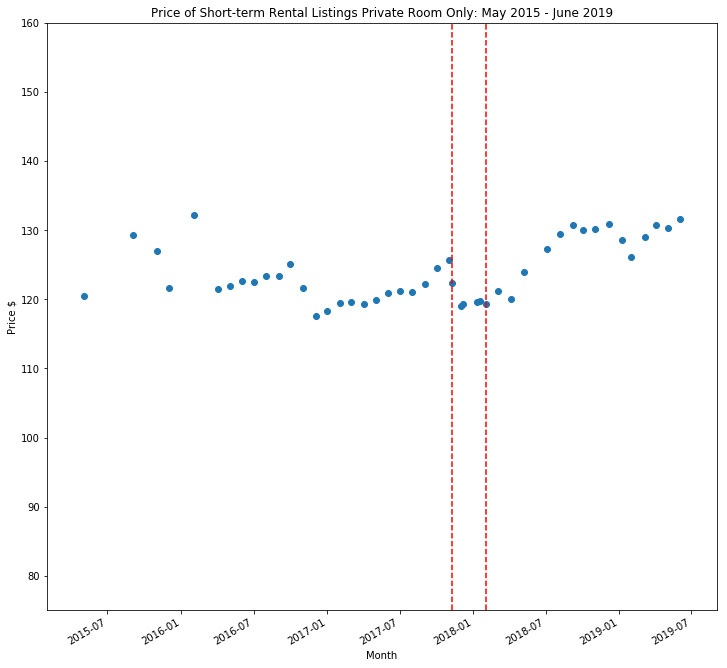

In [116]:
chart_prices(private_room,"Private Room Only",(75,160))


In [117]:
entire_home = listings_short_avail[listings_short_avail['room_type'] == 'Entire home/apt']
entire_home.shape
EH_p = np.asarray(entire_home['price_float'])

EH_1pct = np.percentile(EH_p, 1)
EH_99pct = np.percentile(EH_p, 99)
EH_1pct, EH_99pct

entire_home = entire_home[entire_home['price_float'] <= EH_99pct ]
entire_home = entire_home[entire_home['price_float'] >= EH_1pct ]
entire_home.shape



(112806, 111)

(82.0, 1390.0)

(110552, 111)

C:\Users\ksher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning:

'file_scraped_dt' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

C:\Users\ksher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

'file_scraped_dt' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



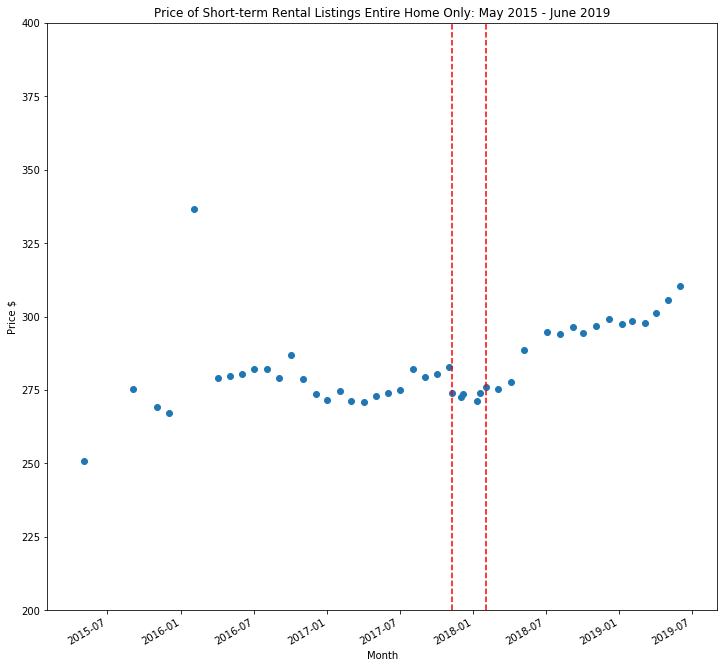

In [118]:
chart_prices(entire_home,"Entire Home Only",(200,400))

In [119]:
PR0 = private_room['2017-11-08']
p0= np.asarray(PR0['price_float'])

PR1 = private_room['2017-11-01']
p1 = np.asarray(PR1['price_float'])


trace1 = go.Histogram(
    x=p1,
    opacity=0.75,
    
    name = 'Private Room on Nov-01-2017'
)
trace2 = go.Histogram(
    x=p0,
    opacity=0.75,
    
    name = 'Private Room on Nov-08-2017'
)


data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Private Room Listings <br> Nov-01-2017 vs Nov-08-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)



In [120]:
PR1 = private_room['2017-11-08']
p1= np.asarray(PR1['price_float'])

PR2 = private_room['2016-11-02']
p2= np.asarray(PR2['price_float'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Private Room on Nov-02-2016'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Private Room on Nov-08-2017'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Private Room Listings <br> Nov-08-2017 vs Nov-02-2016',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)



In [121]:
PR1 = private_room['2018-01-10']
p1= np.asarray(PR1['price_float'])

PR2 = private_room['2017-01-01']
p2= np.asarray(PR2['price_float'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Private Room on Jan-01-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Private Room on Jan-01-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Private Room Listings <br> Jan-01-2018 vs Jan-01-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)


In [122]:
PR1 = private_room['2018-02-02']
p1= np.asarray(PR1['price_float'])

PR2 = private_room['2017-02-02']
p2= np.asarray(PR2['price_float'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Private Room on Feb-02-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Private Room on Feb-02-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Private Room Listings <br> Feb-02-2018 vs Feb-02-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)


In [123]:
PR1 = entire_home['2018-02-02']
p1= np.asarray(PR1['price_float'])

PR2 = entire_home['2017-02-02']
p2= np.asarray(PR2['price_float'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Entire Home/Apartment on Feb-02-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Entire Home/Apartment on Feb-02-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Entire Home Listings <br> Feb-02-2018 vs Feb-02-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)




In [124]:
Feb2018 = private_room['2018-02-02']

del Feb2018['file_scraped_dt']
Feb2018.reset_index()

p_Feb2018 = Feb2018.groupby('id')['price_float'].mean().reset_index()
p_Feb2018.columns=['id', 'price_Feb2018']


Feb2017 = private_room['2017-02-02']

del Feb2017['file_scraped_dt']
Feb2017.reset_index()

p_Feb2017 = Feb2017.groupby('id')['price_float'].mean().reset_index()
p_Feb2017.columns=['id', 'price_Feb2017']

PR_feb_merged = p_Feb2017.merge(p_Feb2018, on = 'id', how = 'inner')
PR_feb_merged.shape




file_scraped_dt        id                            listing_url  \
0         2018-02-02      8014      https://www.airbnb.com/rooms/8014   
1         2018-02-02      8739      https://www.airbnb.com/rooms/8739   
2         2018-02-02      9225      https://www.airbnb.com/rooms/9225   
3         2018-02-02     12522     https://www.airbnb.com/rooms/12522   
4         2018-02-02     18904     https://www.airbnb.com/rooms/18904   
5         2018-02-02     23611     https://www.airbnb.com/rooms/23611   
6         2018-02-02     24463     https://www.airbnb.com/rooms/24463   
7         2018-02-02     24685     https://www.airbnb.com/rooms/24685   
8         2018-02-02     25094     https://www.airbnb.com/rooms/25094   
9         2018-02-02     25463     https://www.airbnb.com/rooms/25463   
10        2018-02-02     25662     https://www.airbnb.com/rooms/25662   
11        2018-02-02     25927     https://www.airbnb.com/rooms/25927   
12        2018-02-02     29557     https://www.airbnb.com/rooms/29557   
13        2018-02-02     41172     https://www.airbnb.com/rooms/41172   
14        2018-02-02     45956     https://www.airbnb.com/rooms/45956   
15        2018-02-02     51073     https://www.airbnb.com/rooms/51073   
16        2018-02-02     52650     https://www.airbnb.com/rooms/52650   
17        2018-02-02     56720     https://www.airbnb.com/rooms/56720   
18        2018-02-02     57676     https://www.airbnb.com/rooms/57676   
19        2018-02-02     59381     https://www.airbnb.com/rooms/59381   
20        2018-02-02     59702     https://www.airbnb.com/rooms/59702   
21        2018-02-02     60659     https://www.airbnb.com/rooms/60659   
22        2018-02-02     62519     https://www.airbnb.com/rooms/62519   
23        2018-02-02     71645     https://www.airbnb.com/rooms/71645   
24        2018-02-02     78651     https://www.airbnb.com/rooms/78651   
25        2018-02-02     82919     https://www.airbnb.com/rooms/82919   
26        2018-02-02     87640     https://www.airbnb.com/rooms/87640   
27        2018-02-02    109883    https://www.airbnb.com/rooms/109883   
28        2018-02-02    114401    https://www.airbnb.com/rooms/114401   
29        2018-02-02    137546    https://www.airbnb.com/rooms/137546   
...              ...       ...                                    ...   
1343      2018-02-02  22705767  https://www.airbnb.com/rooms/22705767   
1344      2018-02-02  22731466  https://www.airbnb.com/rooms/22731466   
1345      2018-02-02  22749858  https://www.airbnb.com/rooms/22749858   
1346      2018-02-02  22751843  https://www.airbnb.com/rooms/22751843   
1347      2018-02-02  22753772  https://www.airbnb.com/rooms/22753772   
1348      2018-02-02  22778447  https://www.airbnb.com/rooms/22778447   
1349      2018-02-02  22795431  https://www.airbnb.com/rooms/22795431   
1350      2018-02-02  22812399  https://www.airbnb.com/rooms/22812399   
1351      2018-02-02  22813226  https://www.airbnb.com/rooms/22813226   
1352      2018-02-02  22814105  https://www.airbnb.com/rooms/22814105   
1353      2018-02-02  22814728  https://www.airbnb.com/rooms/22814728   
1354      2018-02-02  22814781  https://www.airbnb.com/rooms/22814781   
1355      2018-02-02  22847509  https://www.airbnb.com/rooms/22847509   
1356      2018-02-02  22847998  https://www.airbnb.com/rooms/22847998   
1357      2018-02-02  22849534  https://www.airbnb.com/rooms/22849534   
1358      2018-02-02  22886882  https://www.airbnb.com/rooms/22886882   
1359      2018-02-02  22908076  https://www.airbnb.com/rooms/22908076   
1360      2018-02-02  22908078  https://www.airbnb.com/rooms/22908078   
1361      2018-02-02  22908079  https://www.airbnb.com/rooms/22908079   
1362      2018-02-02  22928870  https://www.airbnb.com/rooms/22928870   
1363      2018-02-02  22928933  https://www.airbnb.com/rooms/22928933   
1364      2018-02-02  22941729  https://www.airbnb.com/rooms/22941729   
1365      2018-02-02  22953350  https://www.airbnb.com/rooms/22

file_scraped_dt        id                            listing_url  \
0         2017-02-02  15285867  https://www.airbnb.com/rooms/15285867   
1         2017-02-02   6938818   https://www.airbnb.com/rooms/6938818   
2         2017-02-02  16362304  https://www.airbnb.com/rooms/16362304   
3         2017-02-02   8411606   https://www.airbnb.com/rooms/8411606   
4         2017-02-02   3821592   https://www.airbnb.com/rooms/3821592   
5         2017-02-02  14652409  https://www.airbnb.com/rooms/14652409   
6         2017-02-02   3439823   https://www.airbnb.com/rooms/3439823   
7         2017-02-02   1605483   https://www.airbnb.com/rooms/1605483   
8         2017-02-02  13745138  https://www.airbnb.com/rooms/13745138   
9         2017-02-02      8142      https://www.airbnb.com/rooms/8142   
10        2017-02-02    791573    https://www.airbnb.com/rooms/791573   
11        2017-02-02  14219518  https://www.airbnb.com/rooms/14219518   
12        2017-02-02  12023104  https://www.airbnb.com/rooms/12023104   
13        2017-02-02  16079346  https://www.airbnb.com/rooms/16079346   
14        2017-02-02    226594    https://www.airbnb.com/rooms/226594   
15        2017-02-02    178532    https://www.airbnb.com/rooms/178532   
16        2017-02-02  13814336  https://www.airbnb.com/rooms/13814336   
17        2017-02-02     12041     https://www.airbnb.com/rooms/12041   
18        2017-02-02  13466982  https://www.airbnb.com/rooms/13466982   
19        2017-02-02   1030032   https://www.airbnb.com/rooms/1030032   
20        2017-02-02  16088162  https://www.airbnb.com/rooms/16088162   
21        2017-02-02   4623011   https://www.airbnb.com/rooms/4623011   
22        2017-02-02   3333870   https://www.airbnb.com/rooms/3333870   
23        2017-02-02   6289857   https://www.airbnb.com/rooms/6289857   
24        2017-02-02  16202104  https://www.airbnb.com/rooms/16202104   
25        2017-02-02  15974066  https://www.airbnb.com/rooms/15974066   
26        2017-02-02   6289646   https://www.airbnb.com/rooms/6289646   
27        2017-02-02  14790532  https://www.airbnb.com/rooms/14790532   
28        2017-02-02     12042     https://www.airbnb.com/rooms/12042   
29        2017-02-02   9858310   https://www.airbnb.com/rooms/9858310   
...              ...       ...                                    ...   
2123      2017-02-02  15859766  https://www.airbnb.com/rooms/15859766   
2124      2017-02-02  14827566  https://www.airbnb.com/rooms/14827566   
2125      2017-02-02   3687152   https://www.airbnb.com/rooms/3687152   
2126      2017-02-02  13349040  https://www.airbnb.com/rooms/13349040   
2127      2017-02-02   6653474   https://www.airbnb.com/rooms/6653474   
2128      2017-02-02  15451672  https://www.airbnb.com/rooms/15451672   
2129      2017-02-02    443908    https://www.airbnb.com/rooms/443908   
2130      2017-02-02   8324569   https://www.airbnb.com/rooms/8324569   
2131      2017-02-02  15911997  https://www.airbnb.com/rooms/15911997   
2132      2017-02-02   8782392   https://www.airbnb.com/rooms/8782392   
2133      2017-02-02  10945354  https://www.airbnb.com/rooms/10945354   
2134      2017-02-02   2933105   https://www.airbnb.com/rooms/2933105   
2135      2017-02-02    645139    https://www.airbnb.com/rooms/645139   
2136      2017-02-02   7111375   https://www.airbnb.com/rooms/7111375   
2137      2017-02-02   9650878   https://www.airbnb.com/rooms/9650878   
2138      2017-02-02   9614796   https://www.airbnb.com/rooms/9614796   
2139      2017-02-02   8337954   https://www.airbnb.com/rooms/8337954   
2140      2017-02-02   1783018   https://www.airbnb.com/rooms/1783018   
2141      2017-02-02   6359043   https://www.airbnb.com/rooms/6359043   
2142      2017-02-02   1097535   https://www.airbnb.com/rooms/1097535   
2143      2017-02-02   2123469   https://www.airbnb.com/rooms/2123469   
2144      2017-02-02  14788998  https://www.airbnb.com/rooms/14788998   
2145      2017-02-02  16678379  https://www.airbnb.com/rooms/16

(724, 3)

In [125]:
p1= np.asarray(PR_feb_merged['price_Feb2017'])


p2= np.asarray(PR_feb_merged['price_Feb2018'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Private Room on Feb-02-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Private Room on Feb-02-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Common Private Room Listings <br> Feb-02-2018 vs Feb-02-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),


              )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)


In [126]:
Feb2018 = entire_home['2018-02-02']

del Feb2018['file_scraped_dt']
Feb2018.reset_index()

p_Feb2018 = Feb2018.groupby('id')['price_float'].mean().reset_index()
p_Feb2018.columns=['id', 'price_Feb2018']


Feb2017 = entire_home['2017-02-02']

del Feb2017['file_scraped_dt']
Feb2017.reset_index()

p_Feb2017 = Feb2017.groupby('id')['price_float'].mean().reset_index()
p_Feb2017.columns=['id', 'price_Feb2017']

EH_feb_merged = p_Feb2017.merge(p_Feb2018, on = 'id', how = 'inner')
EH_feb_merged.shape



file_scraped_dt        id                            listing_url  \
0         2018-02-02       958       https://www.airbnb.com/rooms/958   
1         2018-02-02      8339      https://www.airbnb.com/rooms/8339   
2         2018-02-02      8567      https://www.airbnb.com/rooms/8567   
3         2018-02-02     10251     https://www.airbnb.com/rooms/10251   
4         2018-02-02     14125     https://www.airbnb.com/rooms/14125   
5         2018-02-02     23540     https://www.airbnb.com/rooms/23540   
6         2018-02-02     23630     https://www.airbnb.com/rooms/23630   
7         2018-02-02     24723     https://www.airbnb.com/rooms/24723   
8         2018-02-02     27028     https://www.airbnb.com/rooms/27028   
9         2018-02-02     33577     https://www.airbnb.com/rooms/33577   
10        2018-02-02     33578     https://www.airbnb.com/rooms/33578   
11        2018-02-02     39059     https://www.airbnb.com/rooms/39059   
12        2018-02-02     41399     https://www.airbnb.com/rooms/41399   
13        2018-02-02     41423     https://www.airbnb.com/rooms/41423   
14        2018-02-02     42454     https://www.airbnb.com/rooms/42454   
15        2018-02-02     45299     https://www.airbnb.com/rooms/45299   
16        2018-02-02     57561     https://www.airbnb.com/rooms/57561   
17        2018-02-02     59344     https://www.airbnb.com/rooms/59344   
18        2018-02-02     62651     https://www.airbnb.com/rooms/62651   
19        2018-02-02     63247     https://www.airbnb.com/rooms/63247   
20        2018-02-02     63405     https://www.airbnb.com/rooms/63405   
21        2018-02-02     65408     https://www.airbnb.com/rooms/65408   
22        2018-02-02     66119     https://www.airbnb.com/rooms/66119   
23        2018-02-02     70185     https://www.airbnb.com/rooms/70185   
24        2018-02-02     77175     https://www.airbnb.com/rooms/77175   
25        2018-02-02     91957     https://www.airbnb.com/rooms/91957   
26        2018-02-02    117955    https://www.airbnb.com/rooms/117955   
27        2018-02-02    128230    https://www.airbnb.com/rooms/128230   
28        2018-02-02    130665    https://www.airbnb.com/rooms/130665   
29        2018-02-02    134015    https://www.airbnb.com/rooms/134015   
...              ...       ...                                    ...   
1717      2018-02-02  22715454  https://www.airbnb.com/rooms/22715454   
1718      2018-02-02  22718099  https://www.airbnb.com/rooms/22718099   
1719      2018-02-02  22752011  https://www.airbnb.com/rooms/22752011   
1720      2018-02-02  22754295  https://www.airbnb.com/rooms/22754295   
1721      2018-02-02  22754550  https://www.airbnb.com/rooms/22754550   
1722      2018-02-02  22756551  https://www.airbnb.com/rooms/22756551   
1723      2018-02-02  22764131  https://www.airbnb.com/rooms/22764131   
1724      2018-02-02  22770606  https://www.airbnb.com/rooms/22770606   
1725      2018-02-02  22778107  https://www.airbnb.com/rooms/22778107   
1726      2018-02-02  22786440  https://www.airbnb.com/rooms/22786440   
1727      2018-02-02  22796326  https://www.airbnb.com/rooms/22796326   
1728      2018-02-02  22827448  https://www.airbnb.com/rooms/22827448   
1729      2018-02-02  22828955  https://www.airbnb.com/rooms/22828955   
1730      2018-02-02  22834085  https://www.airbnb.com/rooms/22834085   
1731      2018-02-02  22835579  https://www.airbnb.com/rooms/22835579   
1732      2018-02-02  22848016  https://www.airbnb.com/rooms/22848016   
1733      2018-02-02  22907139  https://www.airbnb.com/rooms/22907139   
1734      2018-02-02  22907447  https://www.airbnb.com/rooms/22907447   
1735      2018-02-02  22937513  https://www.airbnb.com/rooms/22937513   
1736      2018-02-02  22943630  https://www.airbnb.com/rooms/22943630   
1737      2018-02-02  22970151  https://www.airbnb.com/rooms/22970151   
1738      2018-02-02  22972678  https://www.airbnb.com/rooms/22972678   
1739      2018-02-02  22986782  https://www.airbnb.com/rooms/22

file_scraped_dt        id                            listing_url  \
0         2017-02-02   2134100   https://www.airbnb.com/rooms/2134100   
1         2017-02-02  11187767  https://www.airbnb.com/rooms/11187767   
2         2017-02-02  16691183  https://www.airbnb.com/rooms/16691183   
3         2017-02-02  14299442  https://www.airbnb.com/rooms/14299442   
4         2017-02-02  15054887  https://www.airbnb.com/rooms/15054887   
5         2017-02-02   5548977   https://www.airbnb.com/rooms/5548977   
6         2017-02-02   9681616   https://www.airbnb.com/rooms/9681616   
7         2017-02-02  12089415  https://www.airbnb.com/rooms/12089415   
8         2017-02-02  15534623  https://www.airbnb.com/rooms/15534623   
9         2017-02-02   4257302   https://www.airbnb.com/rooms/4257302   
10        2017-02-02  16416050  https://www.airbnb.com/rooms/16416050   
11        2017-02-02    571042    https://www.airbnb.com/rooms/571042   
12        2017-02-02   1259611   https://www.airbnb.com/rooms/1259611   
13        2017-02-02  10755749  https://www.airbnb.com/rooms/10755749   
14        2017-02-02   3258040   https://www.airbnb.com/rooms/3258040   
15        2017-02-02   2585167   https://www.airbnb.com/rooms/2585167   
16        2017-02-02   8844548   https://www.airbnb.com/rooms/8844548   
17        2017-02-02  13799488  https://www.airbnb.com/rooms/13799488   
18        2017-02-02    130565    https://www.airbnb.com/rooms/130565   
19        2017-02-02  13942216  https://www.airbnb.com/rooms/13942216   
20        2017-02-02   1144148   https://www.airbnb.com/rooms/1144148   
21        2017-02-02   1480015   https://www.airbnb.com/rooms/1480015   
22        2017-02-02   2965351   https://www.airbnb.com/rooms/2965351   
23        2017-02-02   1280637   https://www.airbnb.com/rooms/1280637   
24        2017-02-02   1555316   https://www.airbnb.com/rooms/1555316   
25        2017-02-02  12057024  https://www.airbnb.com/rooms/12057024   
26        2017-02-02   2046552   https://www.airbnb.com/rooms/2046552   
27        2017-02-02    423063    https://www.airbnb.com/rooms/423063   
28        2017-02-02   9972077   https://www.airbnb.com/rooms/9972077   
29        2017-02-02   1919372   https://www.airbnb.com/rooms/1919372   
...              ...       ...                                    ...   
2812      2017-02-02   3145984   https://www.airbnb.com/rooms/3145984   
2813      2017-02-02  14991676  https://www.airbnb.com/rooms/14991676   
2814      2017-02-02  14484206  https://www.airbnb.com/rooms/14484206   
2815      2017-02-02  12811593  https://www.airbnb.com/rooms/12811593   
2816      2017-02-02   1255826   https://www.airbnb.com/rooms/1255826   
2817      2017-02-02   9491760   https://www.airbnb.com/rooms/9491760   
2818      2017-02-02   2048834   https://www.airbnb.com/rooms/2048834   
2819      2017-02-02  14991821  https://www.airbnb.com/rooms/14991821   
2820      2017-02-02   1180103   https://www.airbnb.com/rooms/1180103   
2821      2017-02-02  14501605  https://www.airbnb.com/rooms/14501605   
2822      2017-02-02   1344752   https://www.airbnb.com/rooms/1344752   
2823      2017-02-02   6915290   https://www.airbnb.com/rooms/6915290   
2824      2017-02-02    837045    https://www.airbnb.com/rooms/837045   
2825      2017-02-02  11059932  https://www.airbnb.com/rooms/11059932   
2826      2017-02-02   2130640   https://www.airbnb.com/rooms/2130640   
2827      2017-02-02   5259978   https://www.airbnb.com/rooms/5259978   
2828      2017-02-02  10043166  https://www.airbnb.com/rooms/10043166   
2829      2017-02-02   6272183   https://www.airbnb.com/rooms/6272183   
2830      2017-02-02   2380632   https://www.airbnb.com/rooms/2380632   
2831      2017-02-02  14845574  https://www.airbnb.com/rooms/14845574   
2832      2017-02-02   3257886   https://www.airbnb.com/rooms/3257886   
2833      2017-02-02  13362637  https://www.airbnb.com/rooms/13362637   
2834      2017-02-02   3319447   https://www.airbnb.com/rooms/3

(938, 3)

In [127]:
p1= np.asarray(EH_feb_merged['price_Feb2017'])


p2= np.asarray(EH_feb_merged['price_Feb2018'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Entire Home/Apartment on Feb-02-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Entire Home/Apartment on Feb-02-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Common Entire Home Listings <br> Feb-02-2018 vs Feb-02-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),


              )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)


In [128]:
sample_1 = np.asarray(PR_feb_merged['price_Feb2017'])
sample_2 = np.asarray(PR_feb_merged['price_Feb2018'])

In [129]:
def t_test(sample_1, sample_2):
    
    def welch_test_statistic(sample_1, sample_2):
        numerator = np.mean(sample_1) - np.mean(sample_2)
        denominator_sq = (np.var(sample_1) / len(sample_1)) + (np.var(sample_2) / len(sample_2))
        return numerator / np.sqrt(denominator_sq)

    stat =  welch_test_statistic(sample_1, sample_2)  
    print(stat)

    def welch_satterhwaithe_df(sample_1, sample_2):
        ss1 = len(sample_1)
        ss2 = len(sample_2)
        df = (
            ((np.var(sample_1)/ss1 + np.var(sample_2)/ss2)**(2.0)) / 
            ((np.var(sample_1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample_2)/ss2)**(2.0)/(ss2 - 1))
        )
        return df

    df = welch_satterhwaithe_df(sample_1, sample_2)
    
    x = np.linspace(-3, 3, num=250)

    fig, ax = plt.subplots(1, figsize=(16, 3))
    students = stats.t(df)
    ax.plot(x, students.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(df))
    ax.legend()
    ax.set_title("Distribution of Welsh's Test Statistic Under the Null Hypothesis")


    x = np.linspace(-3, 3, num=250)

    fig, ax = plt.subplots(1, figsize=(16, 3))
    students = stats.t(df)
    ax.plot(x, students.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(df))
    _ = ax.fill_between(x, students.pdf(x), where=(x >= -1 * stat), color="red", alpha=0.25)
    _ = ax.fill_between(x, students.pdf(x), where=(x <= stat), color="red", alpha=0.25)
    ax.legend()
    ax.set_title("p-value Reigon")

    p_value = students.cdf(stat) + (1 - students.cdf(-stat))
    print("p-value for different price: {:2.2f}".format(p_value))

-0.2790283433831459
p-value for different price: 0.78


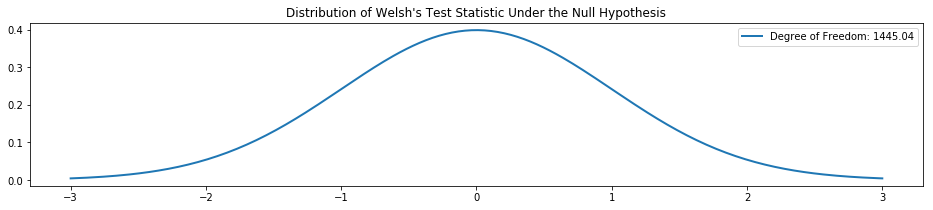

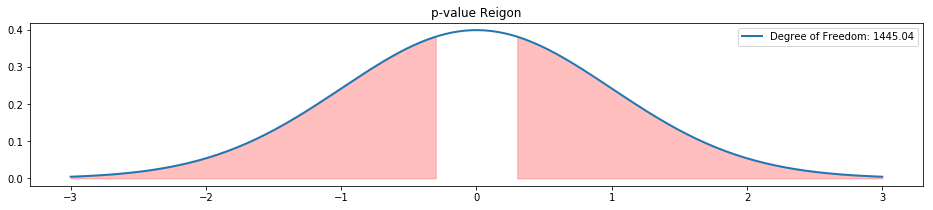

In [130]:
t_test(sample_1, sample_2)

-0.7616030925013014
p-value for different price: 0.45


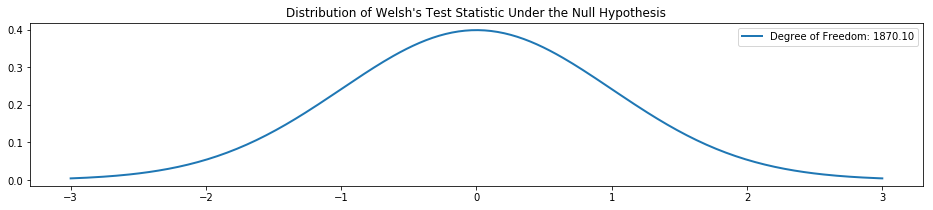

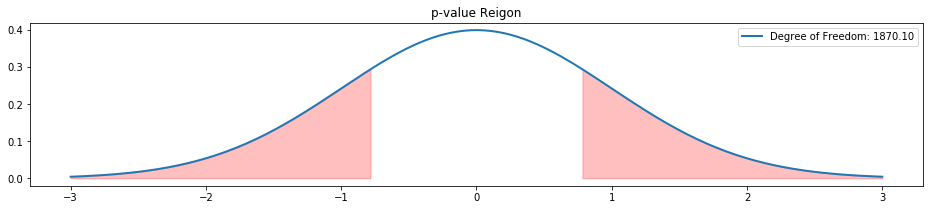

In [131]:
sample_1 = np.asarray(EH_feb_merged['price_Feb2017'])
sample_2 = np.asarray(EH_feb_merged['price_Feb2018'])

t_test(sample_1, sample_2)

In [132]:
EH_feb_merged.head()

id  price_Feb2017  price_Feb2018
0    958          170.0          170.0
1   8339          550.0          575.0
2   8567          255.0          255.0
3  10251          240.0          240.0
4  14125          215.0          215.0

In [133]:
pickle.dump(listings_short_avail, open('../data/listings_short_avail.p','wb'))